# **Древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следующими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

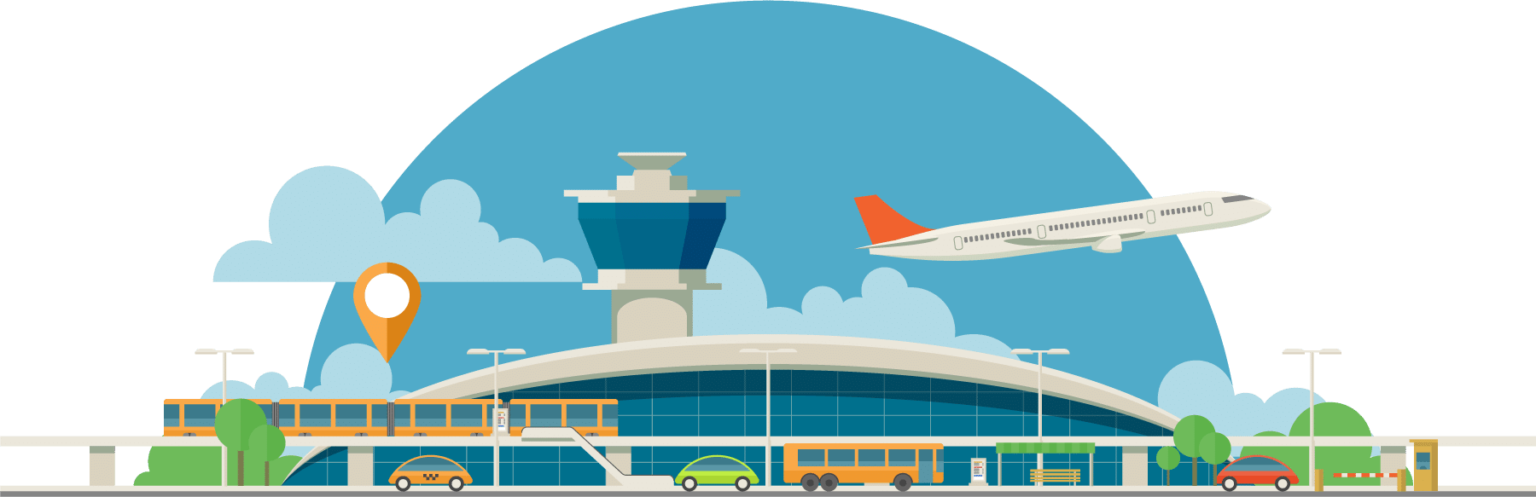

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import pickle

np.random.seed(42)

# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [2]:
import os
import requests

path = os.path.join(os.path.expanduser('~'), '.postgresql')
if not os.path.exists(path):
    os.makedirs(path)
    print(f'Директория {path} создана.')

url = 'https://storage.yandexcloud.net/cloud-certs/CA.pem'
cert_path = os.path.join(path, 'root.crt')

try:
    response = requests.get(url, timeout=10)
    response.raise_for_status()
    
    with open(cert_path, 'wb') as f:
        f.write(response.content)
    print(f'Сертификат успешно сохранен в: {cert_path}')
    
except Exception as e:
    print(f'Произошла ошибка при скачивании: {e}')

Сертификат успешно сохранен в: C:\Users\user\.postgresql\root.crt


### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

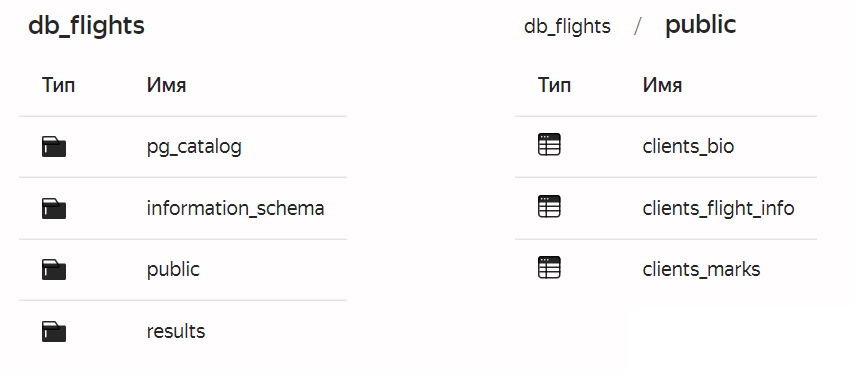



In [3]:
warnings.filterwarnings('ignore', message='.*SQLAlchemy connectable.*')
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')

cert_path = os.path.join(os.path.expanduser("~"), ".postgresql", "root.crt")

conn_params = {
    "host": "YOUR_HOST",
    "port": 6432,
    "sslmode": "verify-full",
    "dbname": "db_flights",
    "user": "YOUR_USER",
    "password": "YOUR_PASSWORD"
    "target_session_attrs": "read-write",
    "sslrootcert": cert_path
}

query = """
SELECT * 
FROM public.clients_bio
JOIN public.clients_flight_info USING (id)
JOIN public.clients_marks USING (id);
"""

try:
    with psycopg2.connect(**conn_params) as conn:
        df = pd.read_sql_query(query, conn)
        df.set_index('id', inplace=True)
        
    print(f"Загрузка завершена успешно. Размер датафрейма: {df.shape}")

except Exception as e:
    print(f"Произошла ошибка: {e}")

Загрузка завершена успешно. Размер датафрейма: (129549, 23)


In [4]:
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [5]:
display(df.head())
print(df.info())
print()

# При выгрузке из базы данных все столбцы распознались как `object`
# Количество признаков не такое большое, поэтому писать функцию, автоматизирующую
# процесс перевода необходимых стобцов в числовые - избыточно
# Поэтому решил составить список из всех колонок, не являющихся явно
# категориальными, и попробовать преобразовать их 

cols_to_num = [
    'age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
    'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking',
    'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
    'Inflight entertainment', 'On-board service', 'Leg room service',
    'Baggage handling', 'Checkin service', 'Inflight service', 'cleanliness'
]

for col in cols_to_num:
    df[col] = pd.to_numeric(df[col], errors='coerce')

num_features = df.select_dtypes(include=['number']).columns
df[num_features] = df[num_features].astype(float)
print(df.dtypes)
print()

cat_cols = df.select_dtypes(include='object').columns
print('Уникальные значения в категориальных столбцах:')
for col in cat_cols:
    print(f'{col}: {df[col].unique()}')
print()

cat_cols_nan = ['Customer Type', 'Type of Travel', 'class']

for col in cat_cols_nan:
    df[col] = df[col].replace('nan', np.nan)

print('Количество пропусков:')
print(df.isna().sum()[df.isna().sum() > 0])

gender   age      Customer Type   Type of Travel     class  \
id                                                               
7     Male  43.0     Loyal Customer  Business travel  Business   
13    Male  24.0  disloyal Customer  Business travel       Eco   
18  Female  61.0     Loyal Customer  Personal Travel       Eco   
31    Male  35.0  disloyal Customer  Business travel  Business   
39  Female  46.0     Loyal Customer  Business travel  Business   

   Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
id                                                                       
7           1963.0                        0.0                      0.0   
13           453.0                       16.0                     30.0   
18           821.0                        0.0                      0.0   
31           212.0                        0.0                      0.0   
39            67.0                        0.0                      0.0   

   Inflight wifi service Departure/Arrival time convenient  ...  \
id                                                          ...   
7                    3.0                               3.0  ...   
13                   2.0                               2.0  ...   
18                   2.0                               5.0  ...   
31                   2.0                               2.0  ...   
39                   3.0                               3.0  ...   

   Online boarding Seat comfort Inflight entertainment On-board service  \
id                                                                        
7              4.0          5.0                    5.0              5.0   
13             2.0          5.0                    5.0              2.0   
18             1.0          5.0                    5.0              5.0   
31             2.0          2.0                    2.0              4.0   
39             5.0          4.0                    4.0              4.0   

   Leg room service Baggage handling Checkin service Inflight service  \
id                                                                      
7               5.0              5.0             4.0              5.0   
13              4.0              4.0             2.0              4.0   
18              2.0              5.0             5.0              5.0   
31              5.0              5.0             5.0              4.0   
39              4.0              4.0             5.0              4.0   

   cleanliness             satisfaction  
id                                       
7          4.0                satisfied  
13         5.0  neutral or dissatisfied  
18         1.0  neutral or dissatisfied  
31         2.0  neutral or dissatisfied  
39         5.0                satisfied  

[5 rows x 23 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   gender                             129549 non-null  object
 1   age                                129549 non-null  object
 2   Customer Type                      129549 non-null  object
 3   Type of Travel                     129549 non-null  object
 4   class                              129549 non-null  object
 5   Flight Distance                    129549 non-null  object
 6   Departure Delay in Minutes         129549 non-null  object
 7   Arrival Delay in Minutes           129549 non-null  object
 8   Inflight wifi service              129549 non-null  object
 9   Departure/Arrival time convenient  129549 non-null  object
 10  Ease of Online booking             129549 non-null  object
 11  Gate location                      129549 non-null  objec

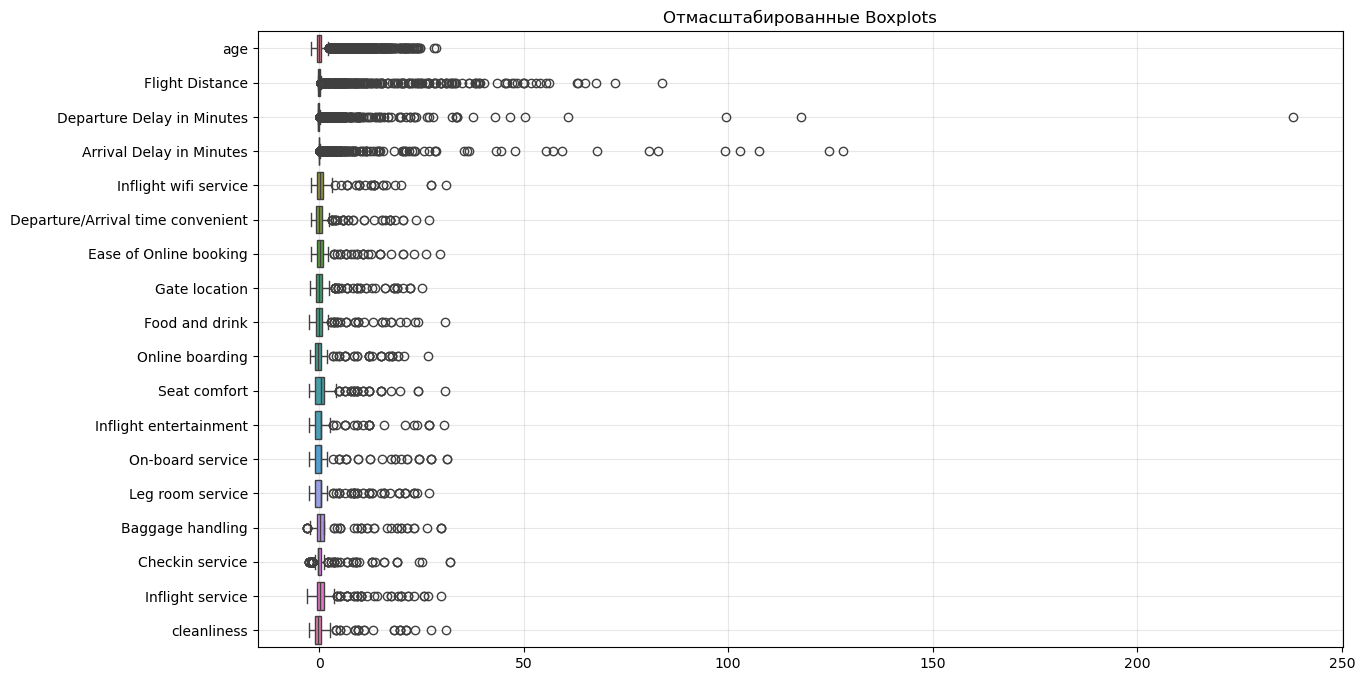

age  Flight Distance  Departure Delay in Minutes  \
count  129234.000000    129455.000000               129442.000000   
mean       40.116951      1322.922158                   15.809026   
std        20.376129      4517.816532                   93.276882   
min         0.000000         0.000000                    0.000000   
25%        27.000000       414.000000                    0.000000   
50%        40.000000       846.000000                    0.000000   
75%        51.000000      1744.000000                   12.000000   
max       621.000000    379620.000000                22227.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count             129042.000000          129505.000000   
mean                  16.656499               2.732327   
std                  109.285072               1.360033   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                14006.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                      129500.000000           129506.000000   
mean                            3.062131                2.760722   
std                             1.559627                1.431048   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               45.000000   

       Gate location  Food and drink  Online boarding   Seat comfort  \
count  129512.000000   129499.000000    129503.000000  129502.000000   
mean        2.981708        3.208141         3.256782       3.445669   
std         1.312873        1.357546         1.381888       1.349713   
min         0.000000        0.000000         0.000000       0.000000   
25%         2.000000        2.000000         2.000000       2.000000   
50%         3.000000        3.000000         3.000000       4.000000   
75%         4.000000        4.000000         4.000000       5.000000   
max        36.000000       45.000000        40.000000      45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count           129504.000000     129505.000000     129503.000000   
mean                 3.361232          3.387259          3.355976   
std                  1.366908          1.335697          1.361670   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 45.000000         45.000000         40.000000   

       Baggage handling  Checkin service  Inflight service    cleanliness  
count     129501.000000    129507.000000     129486.000000  129512.000000  
mean           3.635872         3.309976          3.646927       3.289780  
std            1.222039         1.298827          1.218748       1.347466  
min            0.000000         0.000000          0.000000       0.000000  
25%            3.000000         3.000000          3.000000       2.000000  
50%            4.000000         3.000000          4.000000       3.000000  
75%            5.000000         4.000000          5.000000       4.000000  
max           40.000000        45.000000         40.000000      45.000000

In [6]:
df_scaled = pd.DataFrame(
    StandardScaler().fit_transform(df[num_features]), 
    columns=num_features
)

plt.figure(figsize=(14, 8))
sns.boxplot(data=df_scaled, orient='h')
plt.title("Отмасштабированные Boxplots")
plt.grid(alpha=0.3)
plt.show()

df[num_features].describe()

#### Анализ пропусков и выбросов
В данных присутствует небольшое количество пропусков (до 0.4% от общего количества объектов).
Также, построив график с боксплотами для отмасштабированных признаков и проанализировав `describe`, можно утверждать, что в данных присутствует множество выбросов. Так, для признака `age` максимальное значение составляет 621, что в действительности, конечно же, невозможно. Для признаков, содержащих шкалы оценок, значения должны быть в пределах от 0 до 5, а в данных они достигают 45, что тоже некорректно. Проанализировав и другие признаки, по итогу имеем, что для всех признаков выстречаются выбросы.

### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

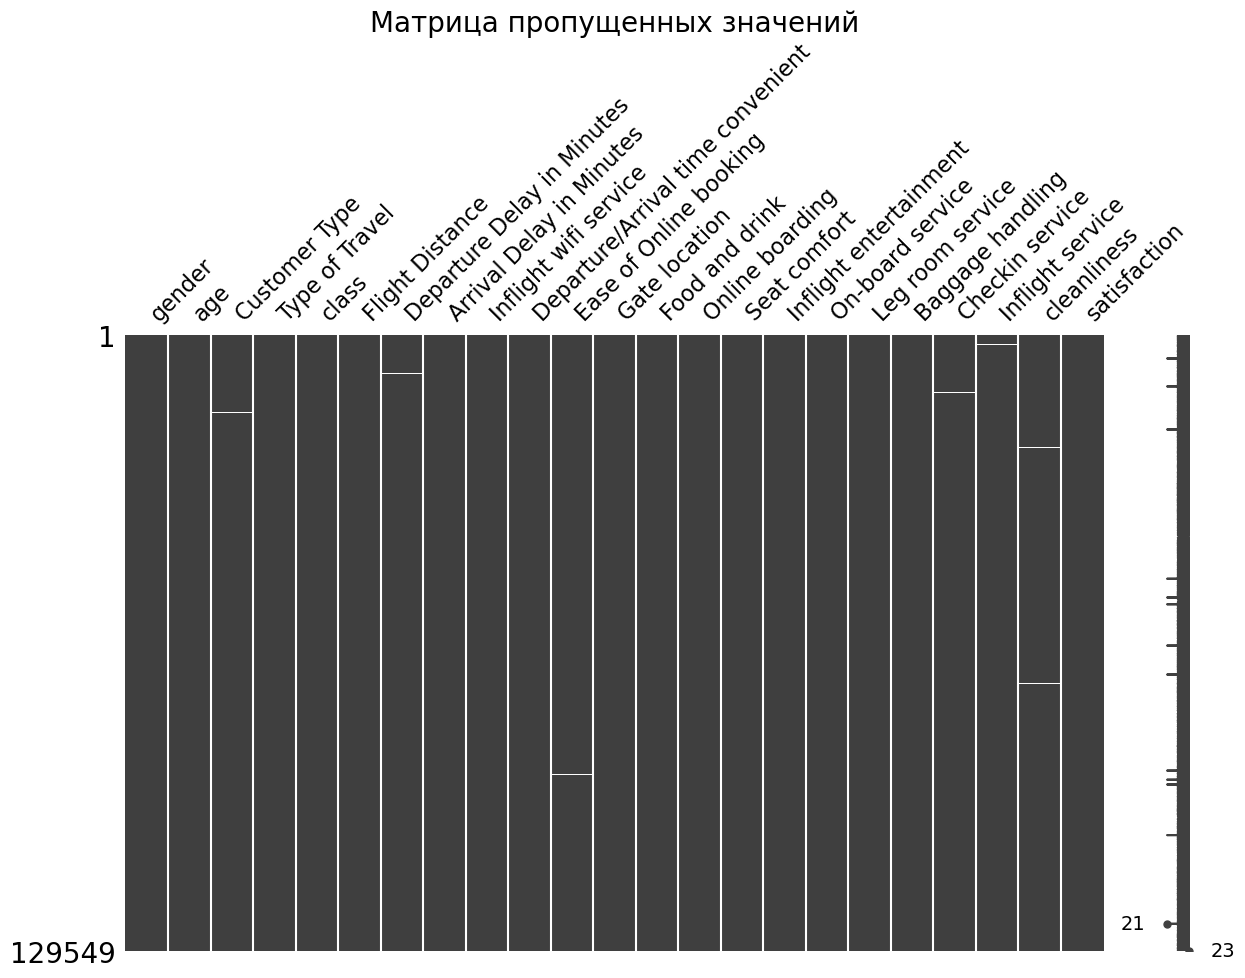

In [7]:
missingno.matrix(df, figsize=(14, 8))
plt.title("Матрица пропущенных значений", fontsize=20)
plt.show()

Для наших данных трудно интерпретировать матрицу пропущенных значений, так как доля пропусков от всех данных очень мала. Белые линии просто тонут среди чёрного цвета, экран не может их корректно отобразить. Поэтому перейдём к построению столбчатой диаграммы в логарифмированной шкале.

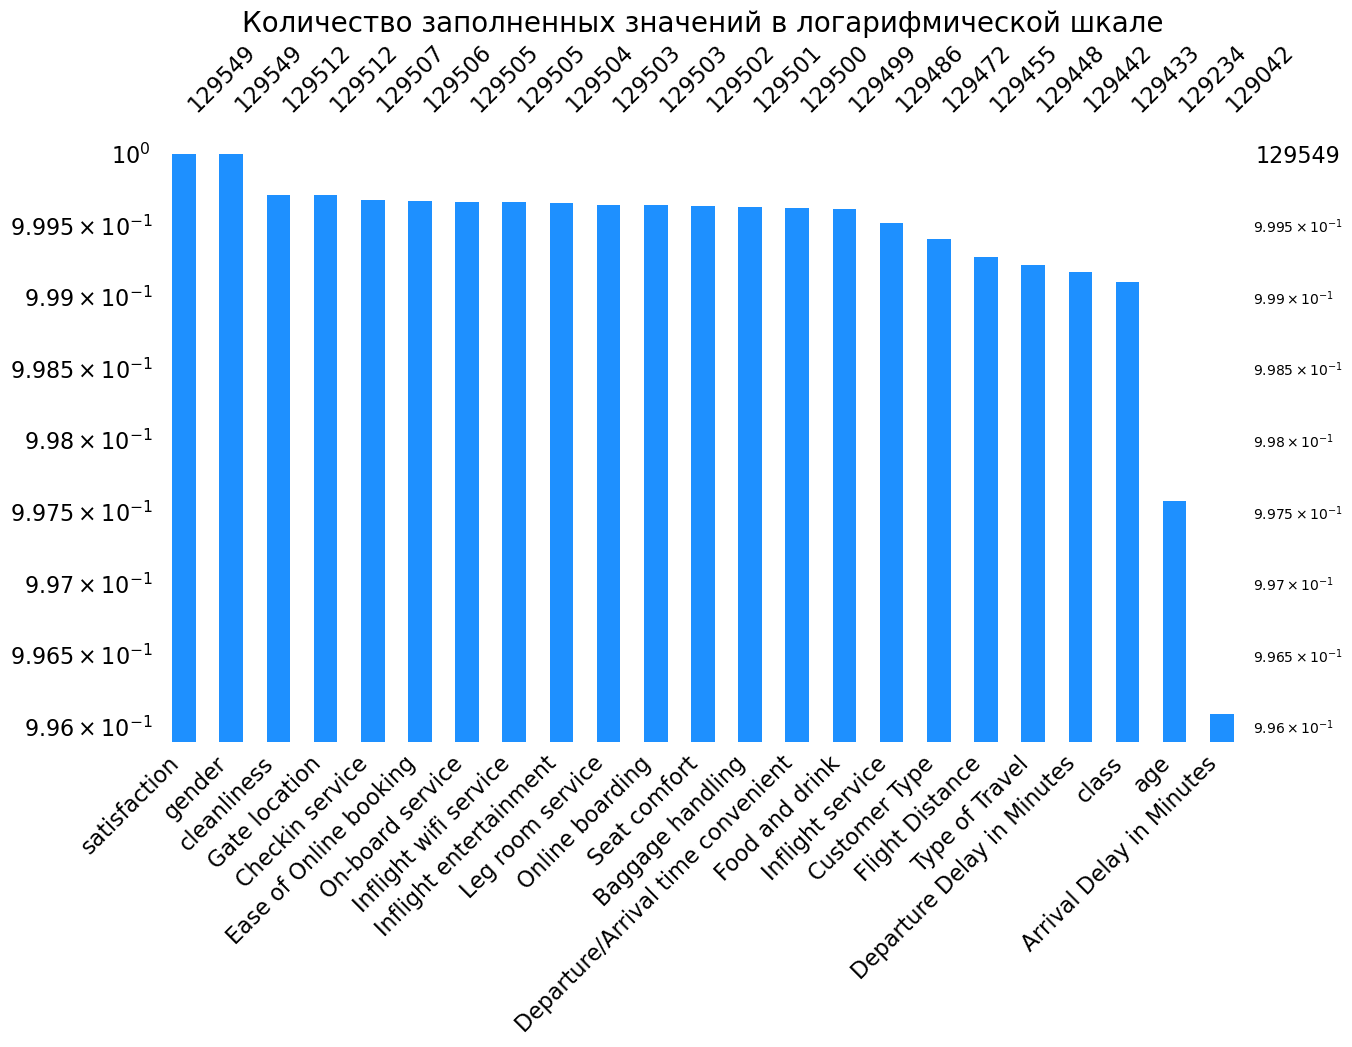

In [8]:
warnings.filterwarnings("ignore", category=UserWarning, module="missingno")

missingno.bar(df, log=True, sort='descending', figsize=(14, 8), color='dodgerblue')
plt.title("Количество заполненных значений в логарифмической шкале", fontsize=20)
plt.show()

Если бы мы использовали линейную шкалу, она бы показала все столбцы одной высоты, поскольку пропусков очень мало. Логарифмическая же шкала позволяет визуализировать такие случаи, грубо говоря, увеличивая верхушку графика, показывая диапазон заполненности от 99.6% до 100%. Это позволяет визуально различить, где пропусков больше, а где меньше.

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [9]:
df_train = df[df.satisfaction != '-']
df_train

gender   age      Customer Type   Type of Travel     class  \
id                                                                   
7         Male  43.0     Loyal Customer  Business travel  Business   
13        Male  24.0  disloyal Customer  Business travel       Eco   
18      Female  61.0     Loyal Customer  Personal Travel       Eco   
31        Male  35.0  disloyal Customer  Business travel  Business   
39      Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129831  Female  28.0     Loyal Customer  Personal Travel       Eco   
129837    Male  66.0     Loyal Customer  Personal Travel       Eco   
129838  Female  59.0     Loyal Customer  Personal Travel       Eco   
129839    Male  61.0     Loyal Customer  Personal Travel       Eco   
129846    Male  44.0     Loyal Customer  Personal Travel       Eco   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
7                1963.0                         0.0                       0.0   
13                453.0                        16.0                      30.0   
18                821.0                         0.0                       0.0   
31                212.0                         0.0                       0.0   
39                 67.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129831            447.0                        23.0                      16.0   
129837            337.0                       199.0                     213.0   
129838            308.0                        32.0                      24.0   
129839            337.0                         0.0                       0.0   
129846            447.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
7                         3.0                                3.0  ...   
13                        2.0                                2.0  ...   
18                        2.0                                5.0  ...   
31                        2.0                                2.0  ...   
39                        3.0                                3.0  ...   
...                       ...                                ...  ...   
129831                    1.0                                3.0  ...   
129837                    2.0                                4.0  ...   
129838                    3.0                                5.0  ...   
129839                    2.0                                4.0  ...   
129846                    2.0                                5.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
7                   4.0           5.0                     5.0   
13                  2.0           5.0                     5.0   
18                  1.0           5.0                     5.0   
31                  2.0           2.0                     2.0   
39                  5.0           4.0                     4.0   
...                 ...           ...                     ...   
129831              1.0           3.0                     3.0   
129837              5.0           5.0                     5.0   
129838              5.0           5.0                     3.0   
129839              2.0           3.0                     3.0   
129846              2.0           5.0                     5.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
id                                                                              
7                    5.0               5.0               5.0              4.0   
13  

In [10]:
assert df_train.shape == (103_644, 23)

In [11]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

gender   age   Customer Type   Type of Travel     class  \
id                                                                
55        Male  36.0  Loyal Customer  Business travel  Business   
79      Female  70.0  Loyal Customer  Personal Travel       Eco   
126       Male  66.0  Loyal Customer  Personal Travel       Eco   
199     Female  60.0  Loyal Customer  Business travel  Business   
263       Male  43.0  Loyal Customer  Personal Travel  Business   
...        ...   ...             ...              ...       ...   
129750    Male  38.0  Loyal Customer  Business travel       Eco   
129771    Male  16.0  Loyal Customer  Personal Travel       Eco   
129798  Female  43.0  Loyal Customer  Personal Travel       Eco   
129868    Male  47.0  Loyal Customer  Business travel  Eco Plus   
129876    Male  28.0  Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
55               3655.0                        40.0                      71.0   
79                108.0                        50.0                      41.0   
126               562.0                        88.0                      84.0   
199              3756.0                        36.0                      24.0   
263               802.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129750            337.0                        92.0                      82.0   
129771            308.0                         2.0                       0.0   
129798            308.0                         0.0                       0.0   
129868            447.0                         0.0                       0.0   
129876            447.0                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
55                        1.0                                1.0  ...   
79                        5.0                                4.0  ...   
126                       2.0                                5.0  ...   
199                       4.0                                4.0  ...   
263                       1.0                                2.0  ...   
...                       ...                                ...  ...   
129750                    4.0                                3.0  ...   
129771                    3.0                                4.0  ...   
129798                    2.0                                4.0  ...   
129868                    3.0                                4.0  ...   
129876                    4.0                                4.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
id                                                                              
55                 1.0              3.0           3.0                     3.0   
79                 4.0              4.0           4.0                     3.0   
126                5.0              2.0           5.0                     5.0   
199                2.0              4.0           5.0                     4.0   
263                2.0              3.0           3.0                     2.0   
...                ...              ...           ...                     ...   
129750             4.0              5.0           4.0                     4.0   
129771             1.0              3.0           5.0                     1.0   
129798             3.0              5.0           5.0                     4.0   
129868             4.0              3.0           4.0                     4.0   
129876             4.0              4.0           1.0                     4.0   

        On-board service  Leg room service  Baggage handling  Checkin service 

In [12]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [13]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [14]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановить пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [15]:
train_mode = X_train.mode().iloc[0]

X_train = X_train.fillna(train_mode)
X_val = X_val.fillna(train_mode)
df_test = df_test.fillna(train_mode)

print('Пропусков в X_train:', X_train.isna().sum().sum())
print('Пропусков в X_val:', X_val.isna().sum().sum())
print('Пропусков в df_test:', df_test.isna().sum().sum())

Пропусков в X_train: 0
Пропусков в X_val: 0
Пропусков в df_test: 0


### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [16]:
display(df_train.describe())
display(df_train.describe(include=['object']))

for col in cat_cols:
    print(f"\nРаспределение {col}:")
    print(df_train[col].value_counts(normalize=True))

age  Flight Distance  Departure Delay in Minutes  \
count  103383.000000    103572.000000               103560.000000   
mean       40.058598      1325.940582                   15.814455   
std        20.357517      4653.636096                   73.965629   
min         0.000000         0.000000                    0.000000   
25%        27.000000       414.000000                    0.000000   
50%        40.000000       844.500000                    0.000000   
75%        51.000000      1744.000000                   12.000000   
max       612.000000    379620.000000                11011.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count             103239.000000          103612.000000   
mean                  16.779279               2.733255   
std                  109.194016               1.358142   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                14006.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                      103603.000000           103611.000000   
mean                            3.064593                2.760325   
std                             1.554340                1.422350   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               45.000000   

       Gate location  Food and drink  Online boarding   Seat comfort  \
count  103614.000000   103609.000000    103607.000000  103603.000000   
mean        2.981335        3.204818         3.255070       3.443288   
std         1.309041        1.352817         1.385608       1.349424   
min         0.000000        0.000000         0.000000       0.000000   
25%         2.000000        2.000000         2.000000       2.000000   
50%         3.000000        3.000000         3.000000       4.000000   
75%         4.000000        4.000000         4.000000       5.000000   
max        36.000000       45.000000        40.000000      45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count           103602.000000     103612.000000     103608.000000   
mean                 3.361026          3.386355          3.356758   
std                  1.360373          1.334901          1.366212   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 40.000000         45.000000         40.000000   

       Baggage handling  Checkin service  Inflight service    cleanliness  
count     103612.000000    103610.000000     103595.000000  103613.000000  
mean           3.635699         3.308185          3.644587       3.289645  
std            1.226960         1.301955          1.212188       1.344059  
min            0.000000         0.000000          0.000000       0.000000  
25%            3.000000         3.000000          3.000000       2.000000  
50%            4.000000         3.000000          4.000000       3.000000  
75%            5.000000         4.000000          5.000000       4.000000  
max           40.000000        45.000000         36.000000      45.000000

gender   Customer Type   Type of Travel     class  \
count   103644          103578           103556    103555   
unique       2               2                2         3   
top     Female  Loyal Customer  Business travel  Business   
freq     52590           84655            71423     49487   

                   satisfaction  
count                    103644  
unique                        2  
top     neutral or dissatisfied  
freq                      58732


Распределение gender:
gender
Female    0.50741
Male      0.49259
Name: proportion, dtype: float64

Распределение Customer Type:
Customer Type
Loyal Customer       0.817307
disloyal Customer    0.182693
Name: proportion, dtype: float64

Распределение Type of Travel:
Type of Travel
Business travel    0.689704
Personal Travel    0.310296
Name: proportion, dtype: float64

Распределение class:
class
Business    0.477881
Eco         0.449993
Eco Plus    0.072126
Name: proportion, dtype: float64

Распределение satisfaction:
satisfaction
neutral or dissatisfied    0.566671
satisfied                  0.433329
Name: proportion, dtype: float64


### Выводы о распределениях значений признаков
#### Анализ целевой переменной и категориальных признаков
Выборка `gender` хорошо сбалансированна, количество мужчин и женщин почти одинаковое. У типа клиентов `Customer type` наблюдается дисбаланс, лояльные клиенты преобладают. В типе полёта `Type of Travel` также наблюдается дисбаланс, но не такой сильный. Преобладают деловые полёты. Классы `Buisness` и `Eco` представлены примерно поровну, класс `Eco Plus` встречается редко. Целевая переменная сбалансированна.

#### Анализ числовых признаков
Как уже было сказано в выводах ранее, в данных присутствует достаточно большое количество выбросов, в том числе экстремальных. Желательно провести очистку перед обучением. Также стоит отметить, что признаки имеют разный масштаб, но для деревьев это не критично.


### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [17]:
num_features = X_train.select_dtypes(include=['number']).columns
th = X_train[num_features].quantile(0.996)

tr_cond = (X_train[num_features] <= th).all(axis=1)
X_train = X_train[tr_cond]
y_train = y_train[tr_cond]

val_cond = (X_val[num_features] <= th).all(axis=1)
X_val = X_val[val_cond]
y_val = y_val[val_cond]

In [18]:
assert df_test.shape == (25_905, 22)

In [19]:
X_train.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  71395.000000     71395.000000                71395.000000   
mean      39.379676      1180.327110                   13.560081   
std       15.103008       987.084943                   30.672384   
min        0.000000         0.000000                    0.000000   
25%       27.000000       409.000000                    0.000000   
50%       40.000000       837.000000                    0.000000   
75%       51.000000      1729.000000                   12.000000   
max       80.000000      3980.000000                  265.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count              71395.000000           71395.000000   
mean                  13.845101               2.729827   
std                   31.043846               1.329804   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                  270.000000               5.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                       71395.000000            71395.000000   
mean                            3.061895                2.757168   
std                             1.524972                1.399303   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                             5.000000                5.000000   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count   71395.000000    71395.000000     71395.000000  71395.000000   
mean        2.977744        3.206401         3.252343      3.440885   
std         1.277994        1.329861         1.349783      1.317559   
min         0.000000        0.000000         0.000000      0.000000   
25%         2.000000        2.000000         2.000000      2.000000   
50%         3.000000        3.000000         3.000000      4.000000   
75%         4.000000        4.000000         4.000000      5.000000   
max         5.000000        5.000000         5.000000      5.000000   

       Inflight entertainment  On-board service  Leg room service  \
count            71395.000000      71395.000000      71395.000000   
mean                 3.358232          3.379102          3.344842   
std                  1.334222          1.289210          1.317095   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                  5.000000          5.000000          5.000000   

       Baggage handling  Checkin service  Inflight service   cleanliness  
count      71395.000000     71395.000000      71395.000000  71395.000000  
mean           3.625310         3.304895          3.637608      3.286631  
std            1.185203         1.267415          1.177825      1.312965  
min            0.000000         0.000000          0.000000      0.000000  
25%            3.000000         3.000000          3.000000      2.000000  
50%            4.000000         3.000000          4.000000      3.000000  
75%            5.000000         4.000000          5.000000      4.000000  
max            5.000000         5.000000          5.000000      5.000000

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [20]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [21]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [22]:
# Решил использовать кастомную палитру, чтобы на графиках интуитивно отличать довольных клиентов
# от недовольных, обозначая первых зеленых цветом, а вторых - красным

mypalette = {
    "satisfied": "#2ecc71", 
    "neutral or dissatisfied": "#e74c3c"
}

In [23]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in cols:
        plt.figure(figsize=(10, 5))
        sns.countplot(x=df[col], hue=y, palette=mypalette)
        
        plt.title(f"Распределение: {col}", fontsize=15)
        plt.xlabel(col, fontsize=12)
        plt.ylabel("Количество клиентов", fontsize=12)
        plt.legend(title='Satisfaction', loc='upper right')
        plt.show()

In [24]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    for col in cols:
        fig, (ax_box, ax_hist) = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(10, 5))
        
        fig.suptitle(f"Распределение: {col}", fontsize=16)
        
        sns.boxplot(x=df[col], y=y, hue=y, ax=ax_box, palette=mypalette, legend=False)
        ax_box.set(xlabel='')
        sns.histplot(x=df[col], hue=y, kde=True, ax=ax_hist, palette=mypalette, alpha=0.6)
        
        plt.show()

In [25]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in cols:
        plt.figure(figsize=(10, 5))
        sns.countplot(x=df[col], hue=y, palette=mypalette)
        
        plt.title(f"Распределение: {col}", fontsize=15)
        plt.xlabel(col, fontsize=12)
        plt.legend(title='Satisfaction')
        plt.show()

Отрисовка.

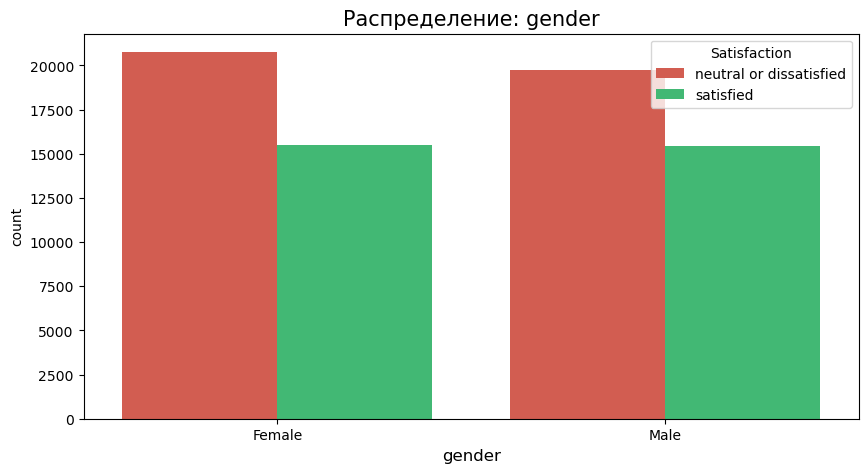

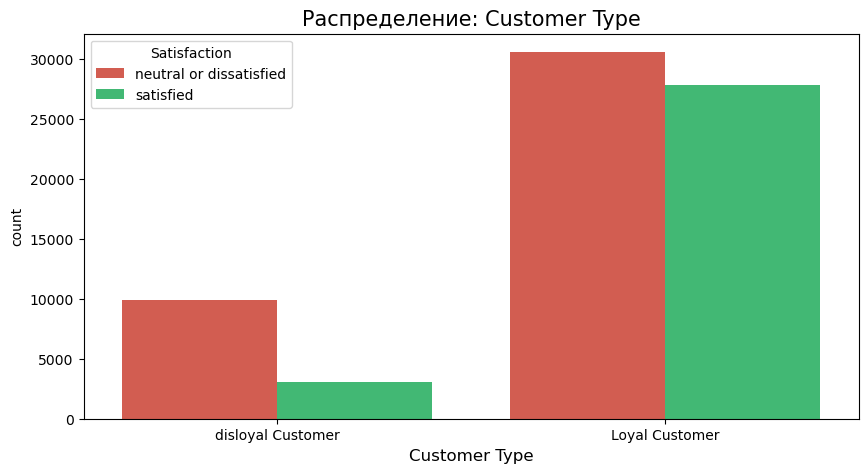

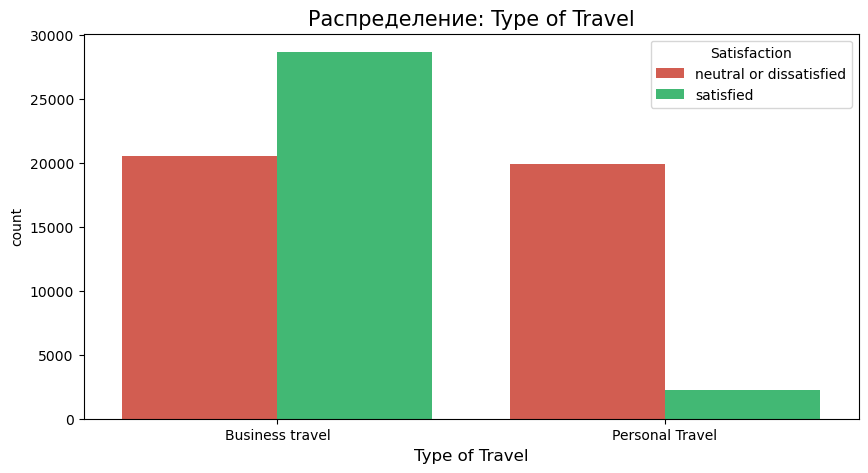

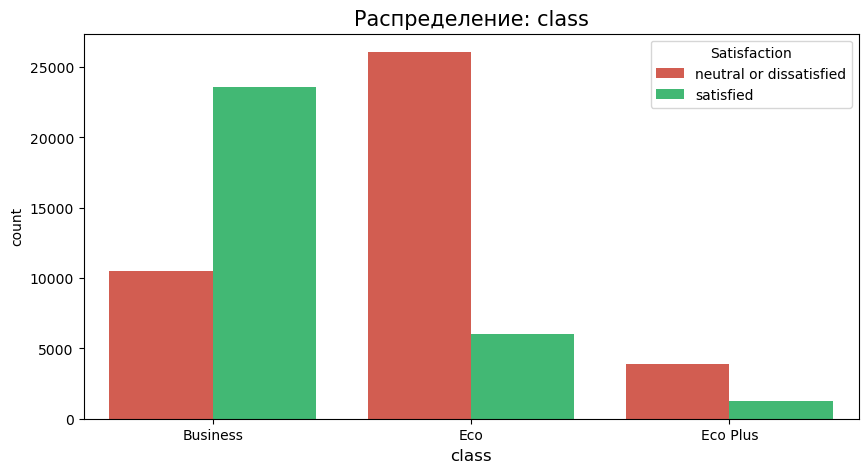

In [26]:
plot_categorical(categorical_cols, X_train, y_train)

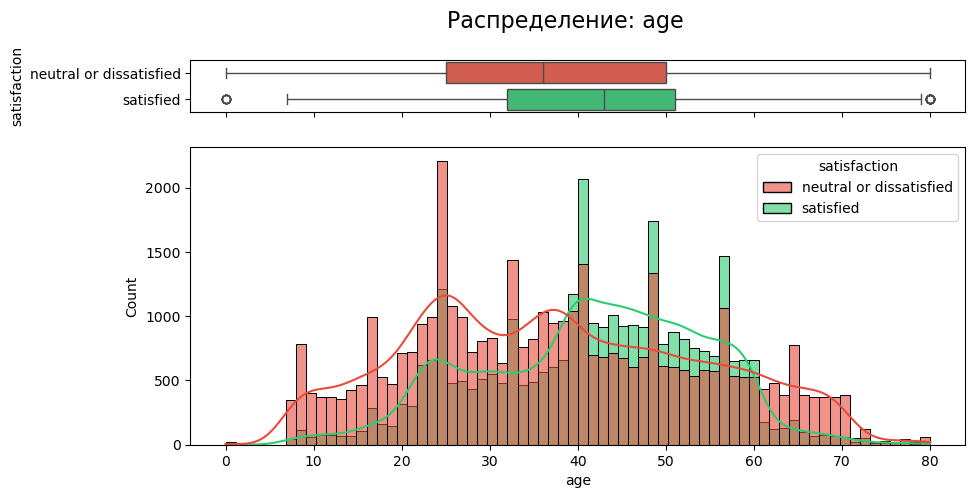

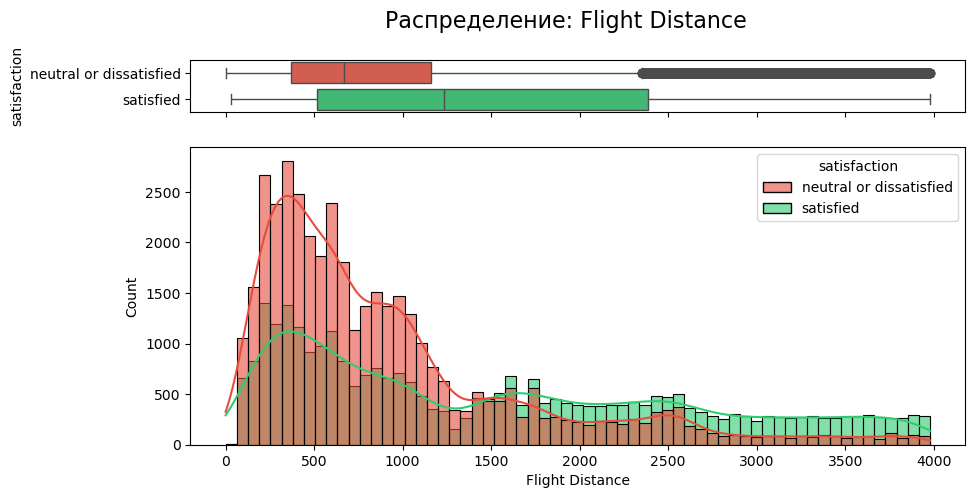

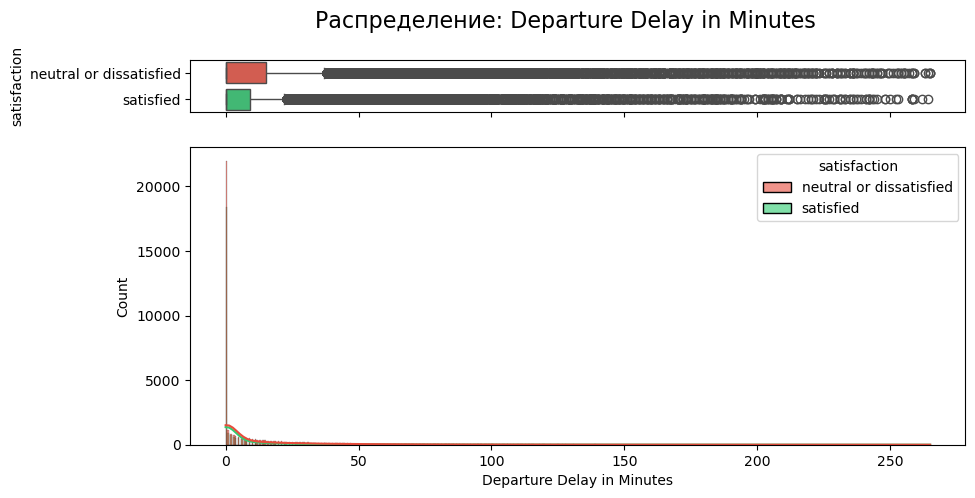

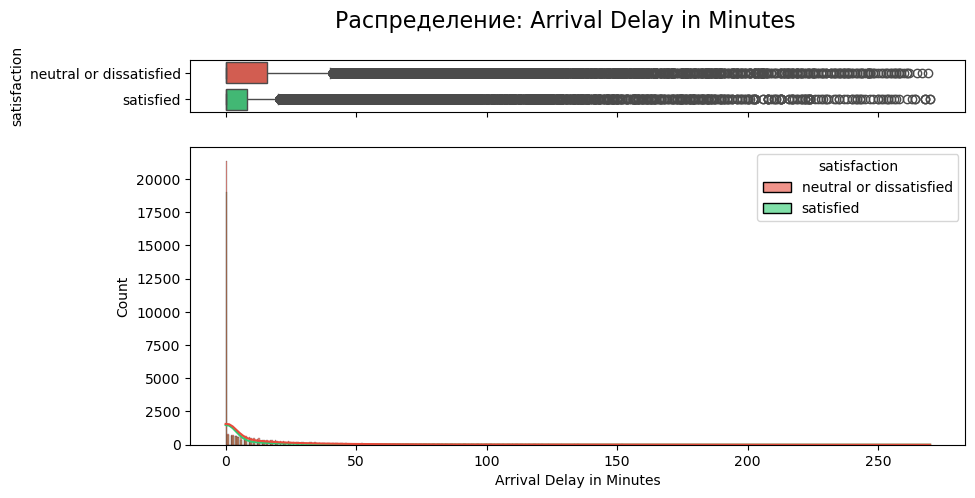

In [27]:
plot_continuous(continuous_cols, X_train, y_train)

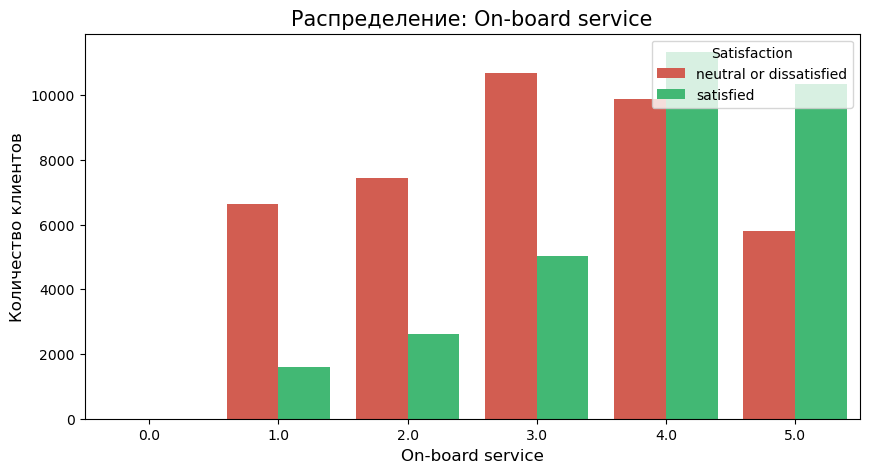

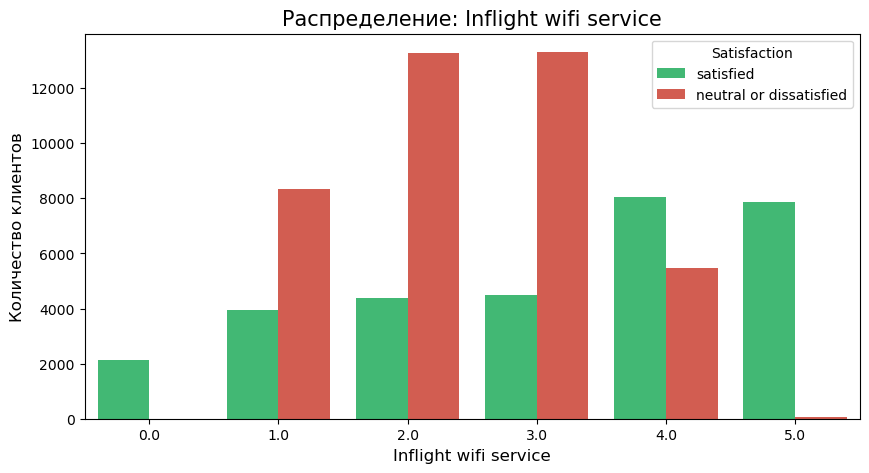

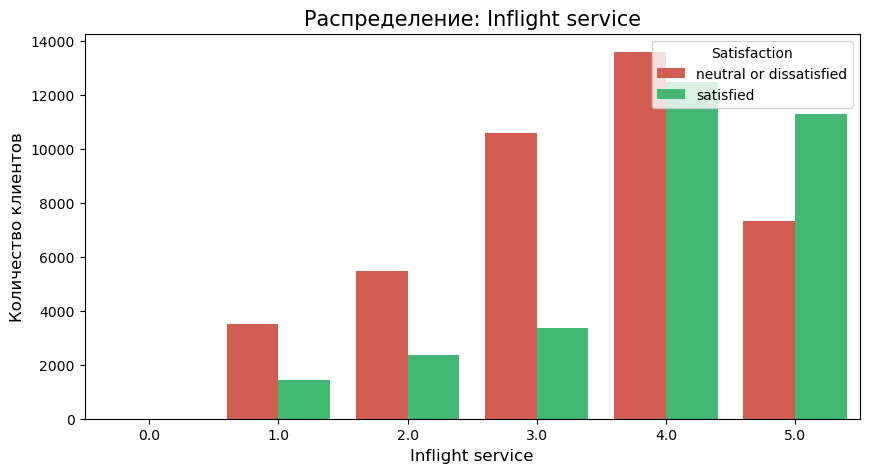

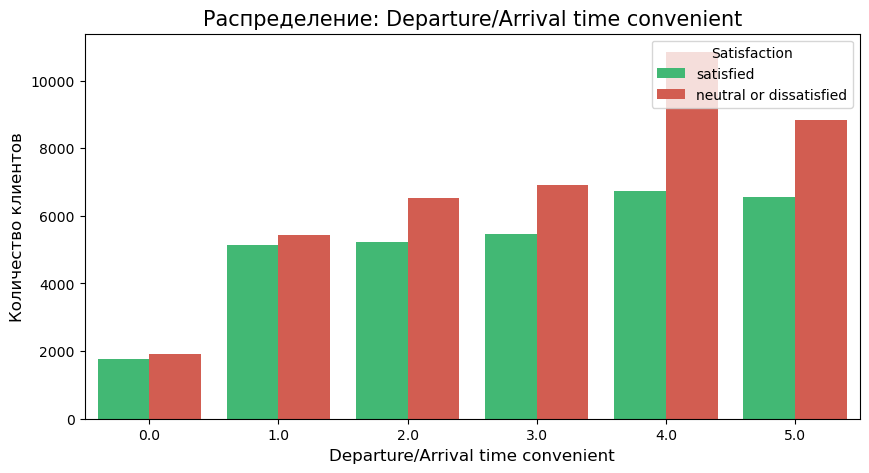

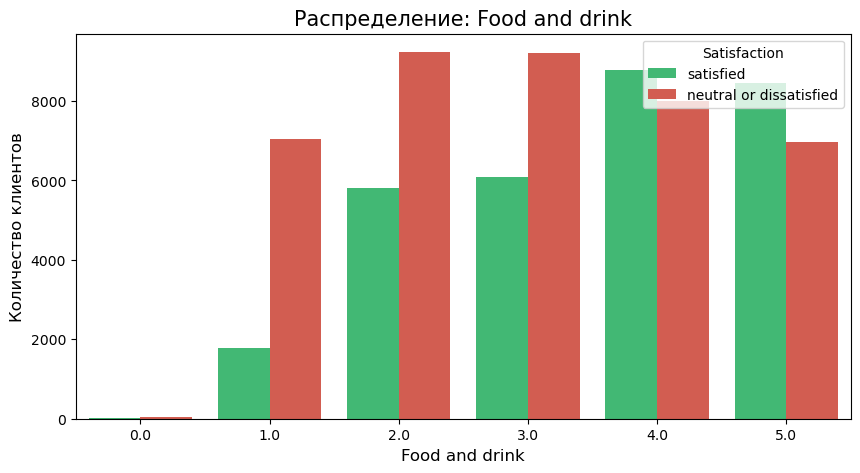

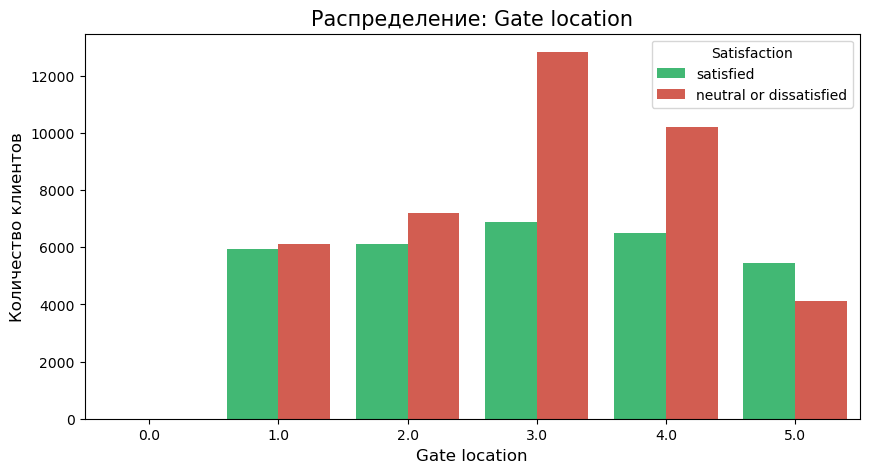

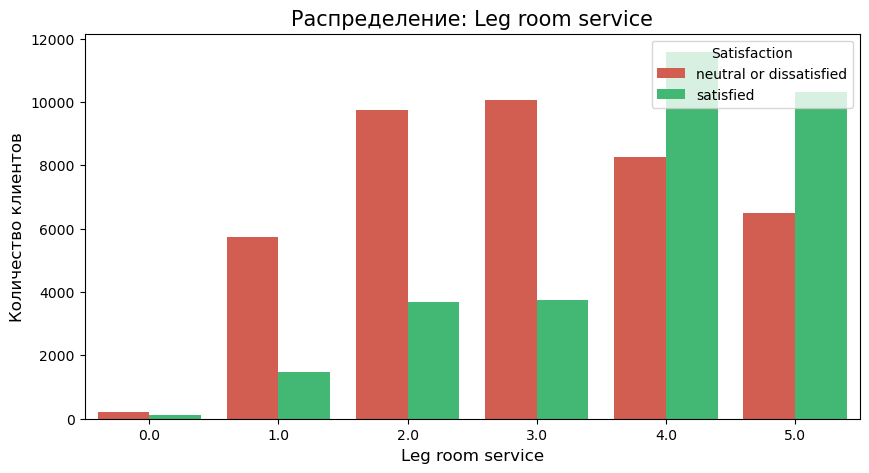

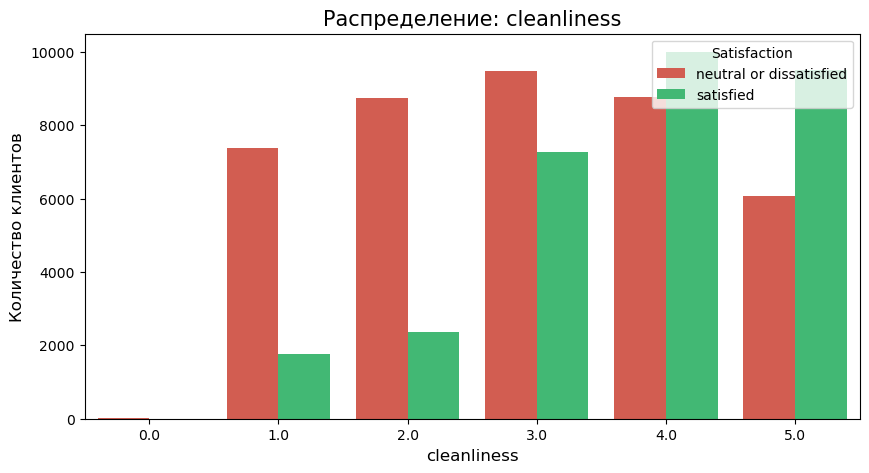

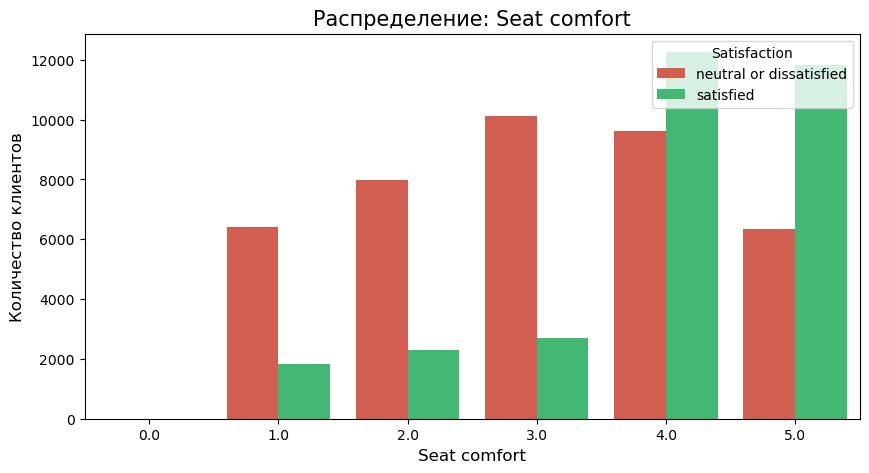

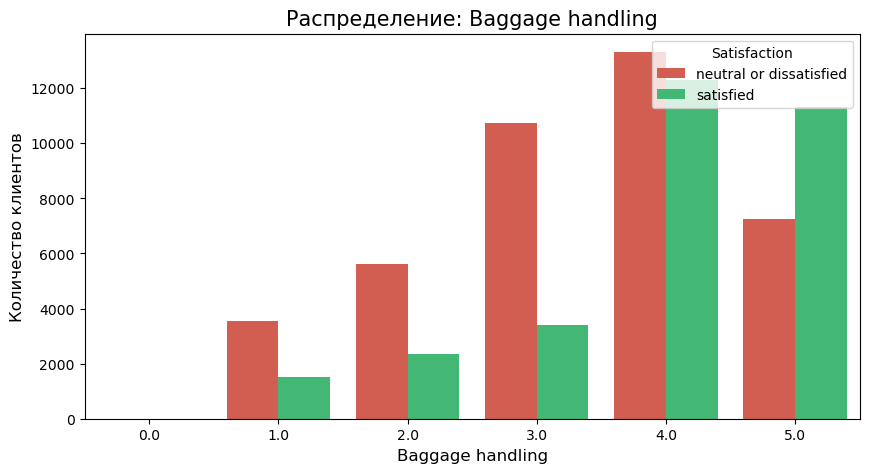

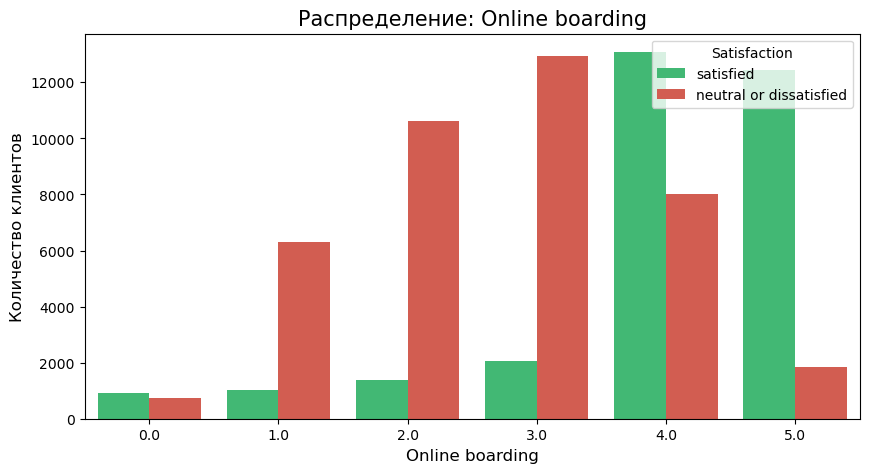

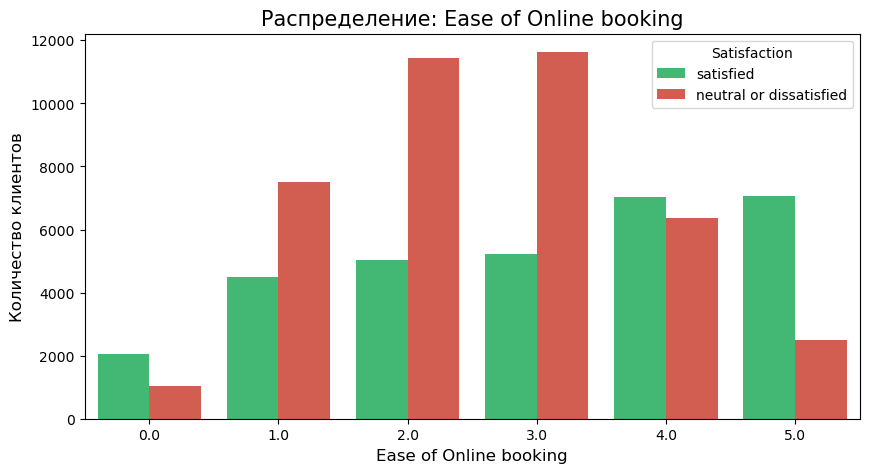

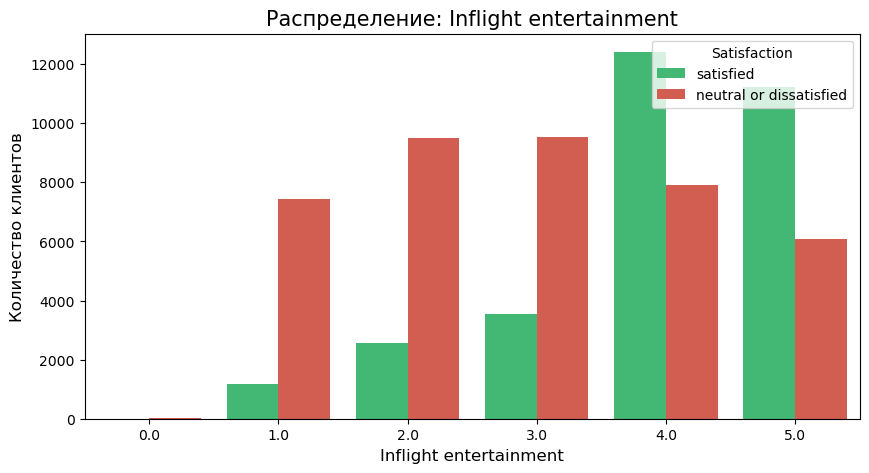

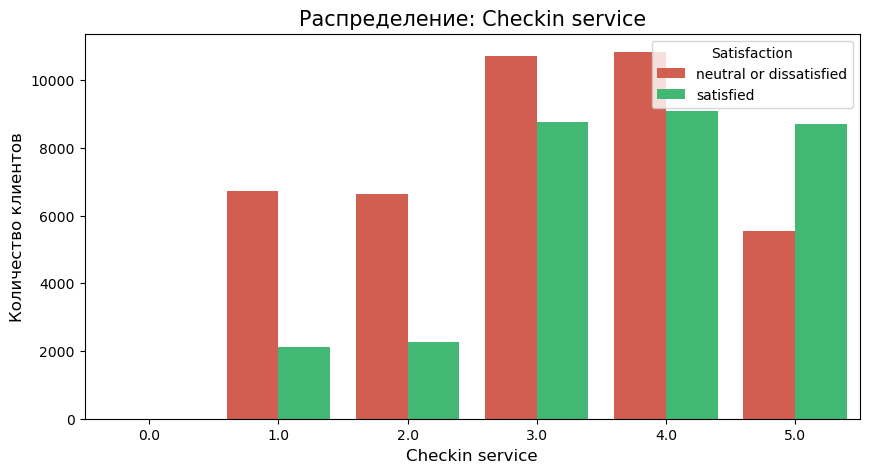

In [28]:
plot_ordinal(ordinal_cols, X_train, y_train)

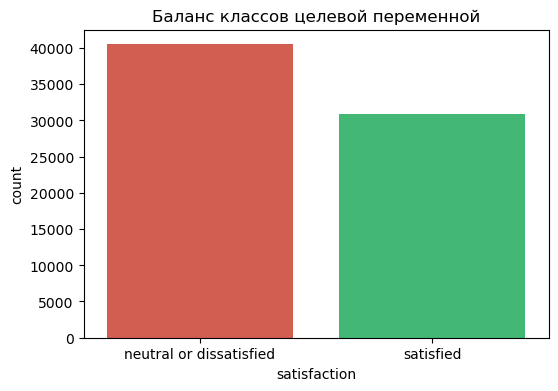

In [29]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train, hue=y_train, palette=mypalette, legend=False)
plt.title("Баланс классов целевой переменной")
plt.show()

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

### Выводы по построенным графикам
#### Распределение категориальных признаков
Тут придётся немного повторяться с выводами, сделанными ранее. У признака `gender` виден баланс: мужчин и женщин практически поровну, при этом и у тех, и у других число неудовлетворенных преобладает.

Внутри признака `Customer Type` присутствует достаточно сильный дисбаланс: лояльных клиентов сильно больше, при этом их степень удовлетворенности выше, чем у нелояльных (что и логично). Внутри признака `Type of Travel` также присутствует дисбаланс: деловых полётов куда больше, при этом и доля удовлетворённых клиентов у них преобладает, в отличии от личных полётов, где клиенты в большинстве своем остаются недовольными.

В признаке `class`, клиенты в бизнес-классе в основном остаются довольны, в отличии от остальных классов.

#### Распределение континуальных признаков
Для признака `age` можно заметить, что люди от 40 до 60 лет в основном остаются довольны полётом, в отличии от других возрастных категорий. Можно предположить, что молодые люди реже летают бизнес-классом и чаще остаются недовольны. Медиана возраста удовлетворенных клиентов выше, чем у неудовлетворенных (примено 45 против 35). 

По признаку `Flight Distance` наблюдения следующие: на коротких полётах до 1000км ярко выраженный пик недовольных пассажиров. У довольных более равномерное распределение и, начиная с 1500 км, количество таких клиентов преобладает над количеством недовольных. Это может объяснятся тем, что на коротких дистанциях часто меньше сервиса, самолеты хуже и нет питания. На длительных же рейсах чаще встречается бизнес-класс и полноценный сервис. 

Для признаков задержек `Arrival Delay` и `Departure Dela`' межквартильный размах очень мал и мы видем распределение с правым хвостом. При этом у удовлетворенных клиентов сам ящик сильно меньше, чем у удовлетворенных. Получается, что задержки полётов здесь - явление не частое, не если они всё же происходят, то это оказывает довольно сильное влияние на пассажиров и число неудовлетворенных растёт.

#### Распределение порядковых признаков
Почти у всех порядковых признаков тенденция одинаковая: чем выше оценка, тем больше доля довольных клиентов. Особенно ярко это выражено для признаков `Online boarding`, `Inflight wifi service`, `Inflight entertainment` и `Seat comfort`. А вот у признаков `Gate location` и `Departure/Arrival time convenient` баланс классов почти не изменяется от оценки к оценке.

#### Распределение целевой переменной 
Целевая переменная сбалансирована.

### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

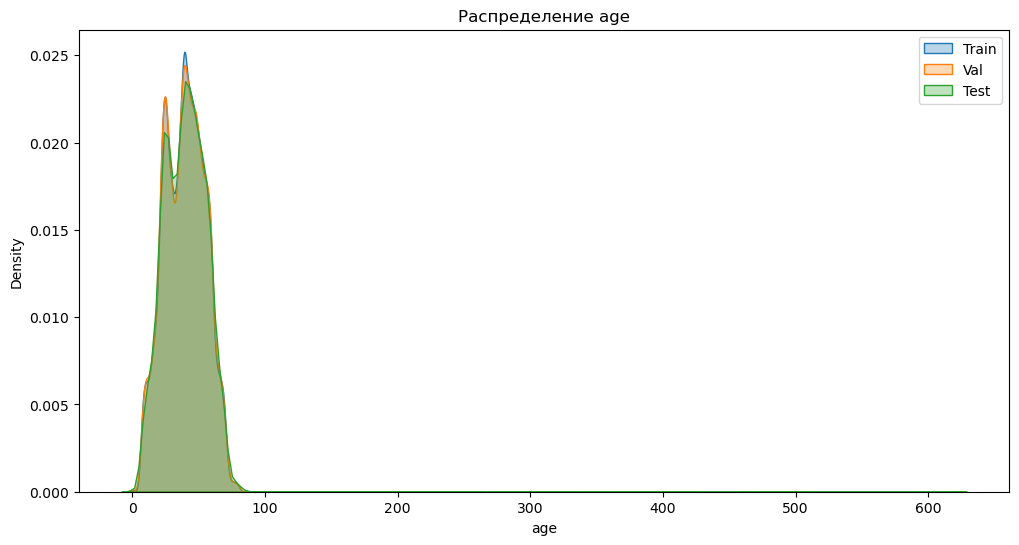

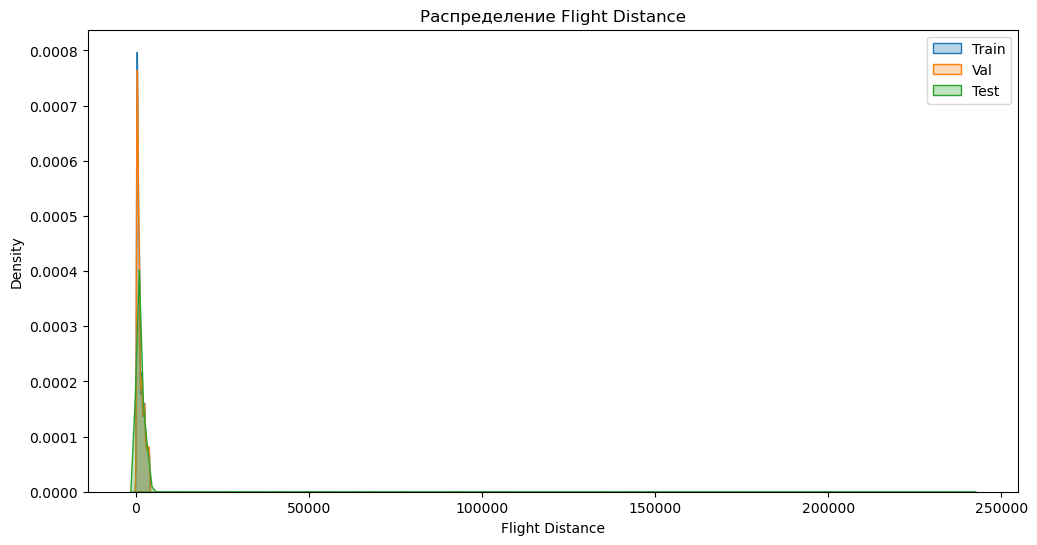

In [30]:
plt.figure(figsize=(12, 6))
sns.kdeplot(X_train['age'], label='Train', fill=True, alpha=0.3)
sns.kdeplot(X_val['age'], label='Val', fill=True, alpha=0.3)
sns.kdeplot(df_test['age'], label='Test', fill=True, alpha=0.3)
plt.title('Распределение age')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(X_train['Flight Distance'], label='Train', fill=True, alpha=0.3)
sns.kdeplot(X_val['Flight Distance'], label='Val', fill=True, alpha=0.3)
sns.kdeplot(df_test['Flight Distance'], label='Test', fill=True, alpha=0.3)
plt.title('Распределение Flight Distance')
plt.legend()
plt.show()

При анализе графиков протности распределения видно, что признаки в тренировочной, валидационной и тестовой выборке распределены практически одинаково. Это подтверждает репрезентативность разбиения.

### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [31]:
log_cols = ['Departure Delay in Minutes', 'Arrival Delay in Minutes']

for col in log_cols:
    X_train[col] = np.log1p(X_train[col])
    X_val[col] = np.log1p(X_val[col])
    df_test[col] = np.log1p(df_test[col])

Построение.

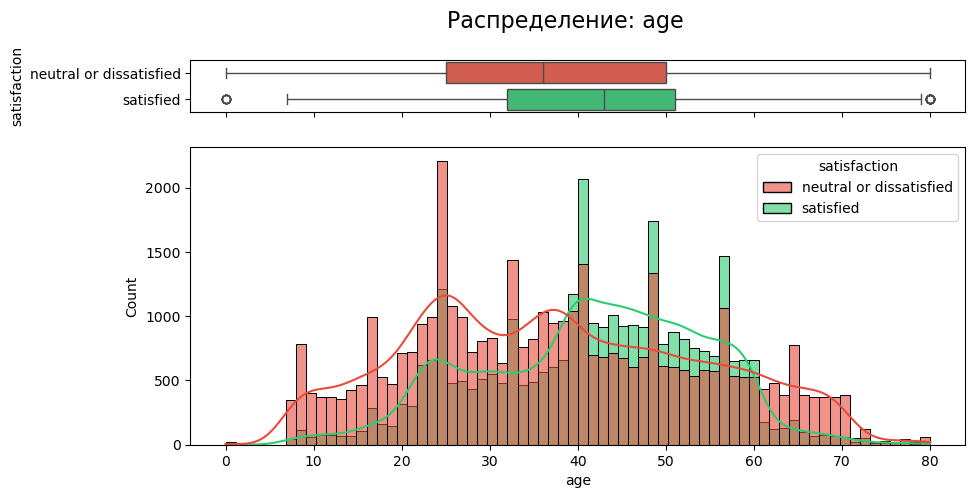

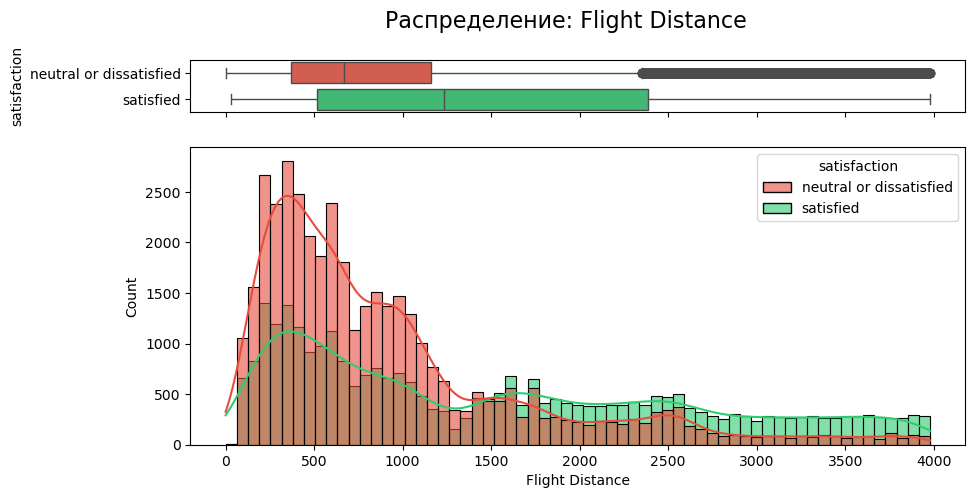

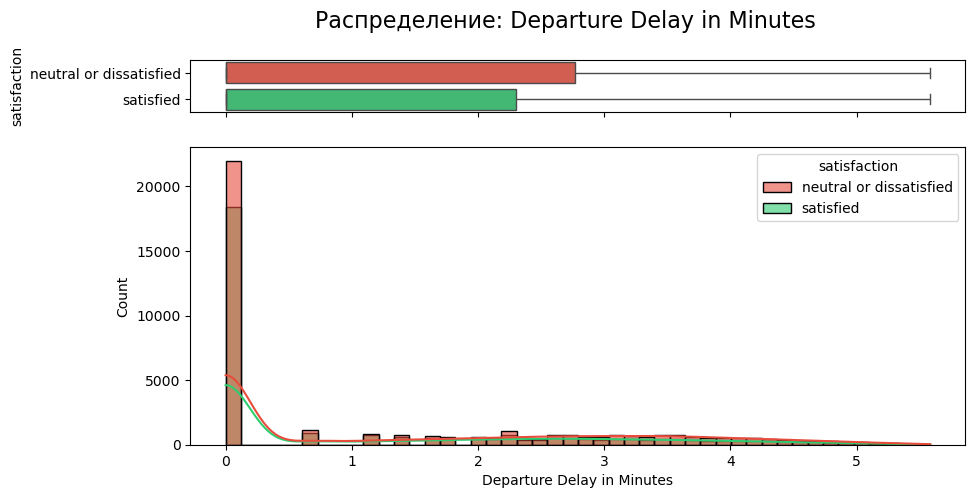

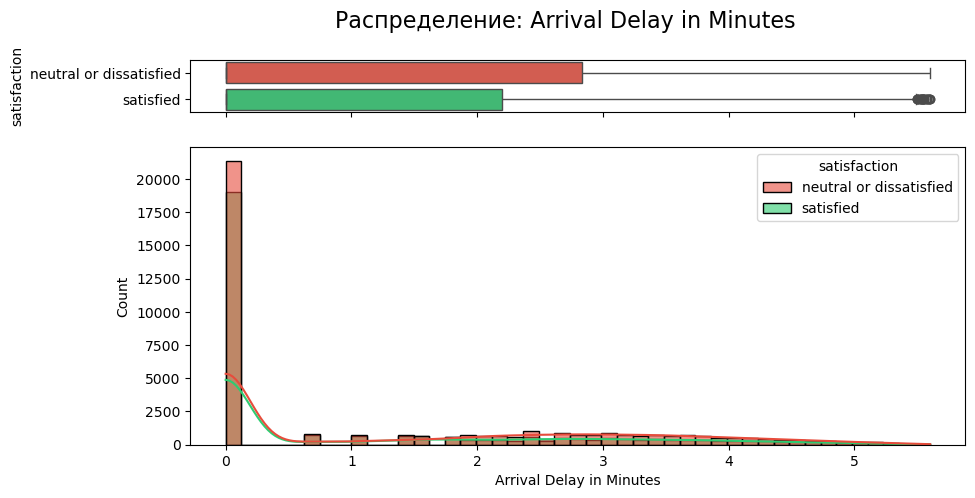

In [32]:
plot_continuous(continuous_cols, X_train, y_train)

Задержки имеют длинный правый хвост, поэтому их полезно рассмотреть в логарифмической шкале, что помогает анализировать большие диапозоны изменений. Теперь мы можем видеть плотность распределения задержек из правого хвоста. Таким образом мы сделали данные более однородными и улучшили интерпретируемость визуализаций.

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

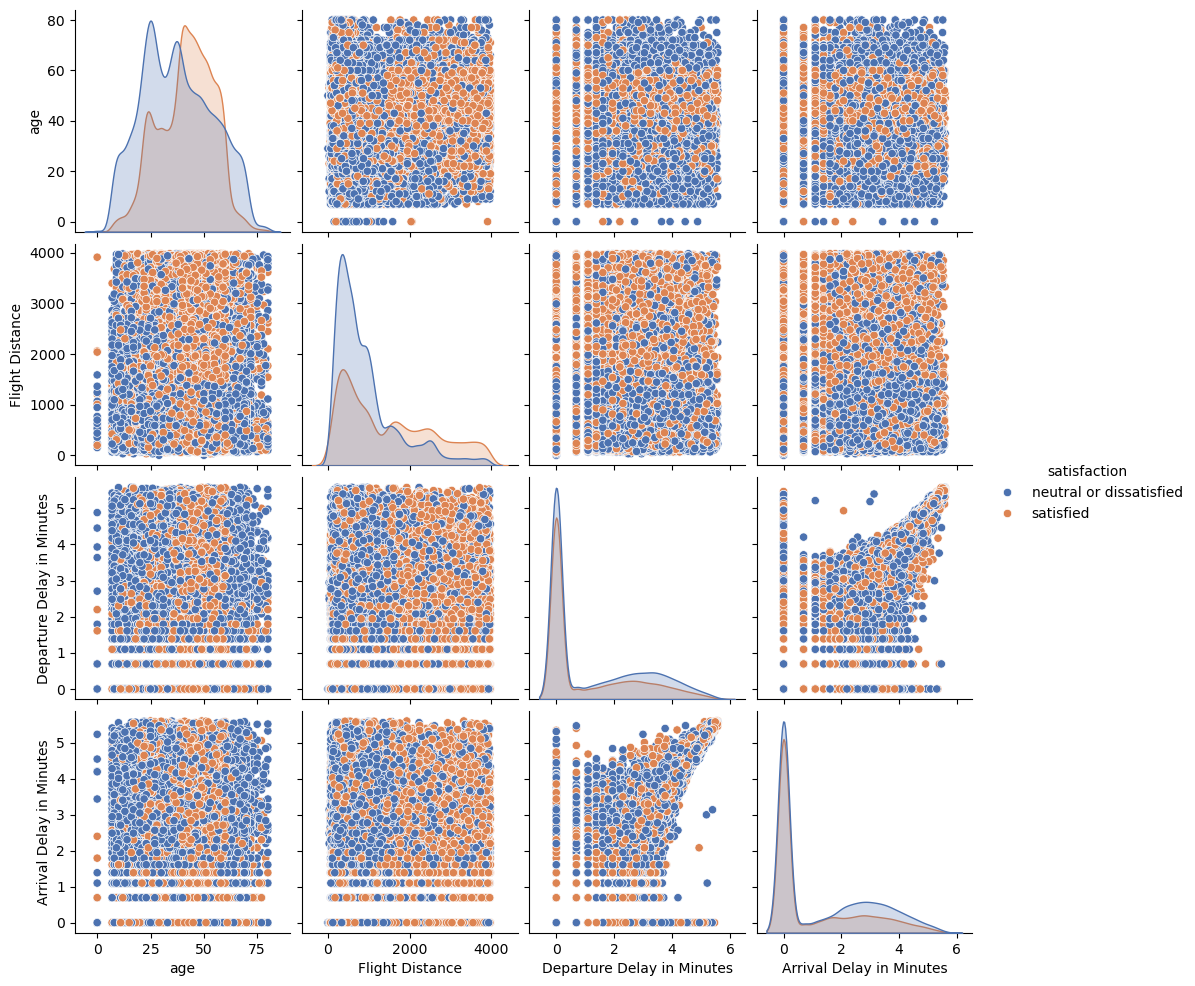

In [33]:
pl = X_train[continuous_cols].copy()
pl['satisfaction'] = y_train

sns.pairplot(pl, hue='satisfaction', diag_kind='kde', palette='deep')
plt.show()

# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [34]:
y_train = y_train.map({'satisfied': 1, 'neutral or dissatisfied': 0})
y_val = y_val.map({'satisfied': 1, 'neutral or dissatisfied': 0})

print(y_train.value_counts())                            

satisfaction
0    40484
1    30911
Name: count, dtype: int64


In [35]:
cat_cols = X_train.select_dtypes(include='object').columns.tolist()

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

ohe.fit(X_train[cat_cols])

X_train_tr = ohe.transform(X_train[cat_cols])
X_train_ohe = pd.DataFrame(X_train_tr, columns=ohe.get_feature_names_out(cat_cols), index=X_train.index)
X_train_enc = pd.concat([X_train.drop(cat_cols, axis=1), X_train_ohe], axis=1)

X_val_tr = ohe.transform(X_val[cat_cols])
X_val_ohe = pd.DataFrame(X_val_tr, columns=ohe.get_feature_names_out(cat_cols), index=X_val.index)
X_val_enc = pd.concat([X_val.drop(cat_cols, axis=1), X_val_ohe], axis=1)

df_test_tr = ohe.transform(df_test[cat_cols])
df_test_ohe = pd.DataFrame(df_test_tr, columns=ohe.get_feature_names_out(cat_cols), index=df_test.index)
df_test_enc = pd.concat([df_test.drop(cat_cols, axis=1), df_test_ohe], axis=1)

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [36]:
dt_def = DecisionTreeClassifier(random_state=42)

dt_def.fit(X_train_enc, y_train)
y_val_pred = dt_def.predict(X_val_enc)

accuracy = accuracy_score(y_val, y_val_pred)

print(f"Accuracy на валидации для стандартного решающего дерева : {accuracy:.3f}")

Accuracy на валидации для стандартного решающего дерева : 0.943


## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [37]:
X_train_np = X_train_enc.values
y_train_np = y_train.values
X_val_np = X_val_enc.values
y_val_np = y_val.values

error_dt, bias_dt, var_dt = bias_variance_decomp(dt_def, X_train_np, y_train_np,  X_val_np, y_val_np, loss='0-1_loss', random_seed=42)
error_dt, bias_dt, var_dt

(np.float64(0.06177369281045752),
 np.float64(0.04049019607843137),
 np.float64(0.04602728758169934))

По результатам видим, что разброс получился больше смещения. Это говорит о том, что дерево переобучено.

Такой результат вполне ожидаем, потому что мы не ограничивали гиперпараметры и дерево могло получиться слишком глубоким.

### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [38]:
print(f'Глубина дерева: {dt_def.get_depth()}')
print(f'Количество листьев: {dt_def.get_n_leaves()}')

Глубина дерева: 31
Количество листьев: 2099


Подтвердилось сказанное выше: дерево получилось слишком глубоким и ветвистым. Это доказывает, что дерево переобучено.

### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

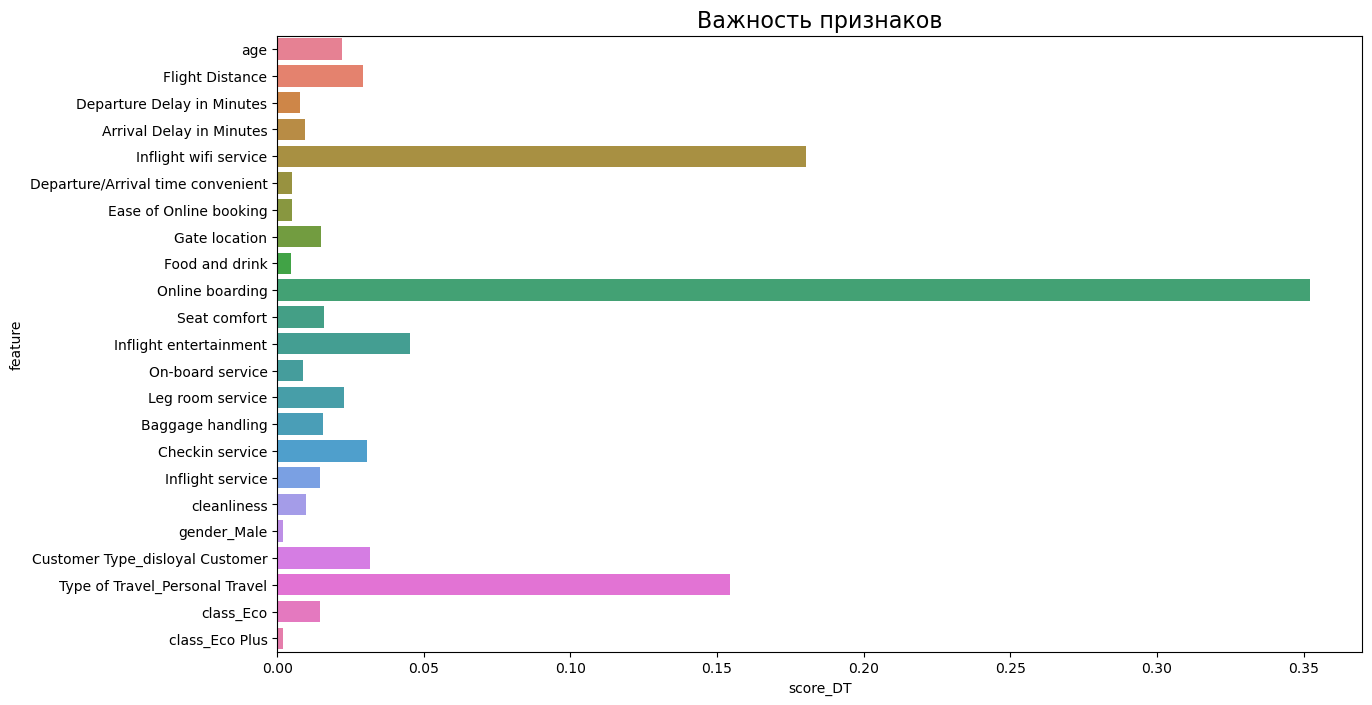

Самые важные признаки:
                            feature  score_DT
9                   Online boarding  0.352331
4             Inflight wifi service  0.180278
20   Type of Travel_Personal Travel  0.154575
11           Inflight entertainment  0.045442
19  Customer Type_disloyal Customer  0.031711
15                  Checkin service  0.030672
1                   Flight Distance  0.029417


In [39]:
fimp_df = pd.DataFrame({'feature': X_train_enc.columns, 'score_DT': dt_def.feature_importances_})

plt.figure(figsize=(14, 8))
sns.barplot(data=fimp_df, x='score_DT', y='feature', hue='feature', palette='husl', legend=False)

plt.title('Важность признаков', fontsize=16)
plt.xlabel("score_DT")
plt.ylabel("feature")

plt.show()

print('Самые важные признаки:')
print(fimp_df.sort_values(by='score_DT', ascending=False).head(7))

Особенно сильное влияние оказывает признак `Online boarding`. Видимо, пассажиры, у которых получилось сделать бронь онлайн, уже оказываются довольны, а те, у кого не вышло - наоборот, оказываются неудовлетворены. Также сильное влияние оказывают признаки `Inflight wifi service` и `Personal Travel`. Отсутствие интернета сильно сказывается на комфорте человека, что ожидаемо. Также, как уже было выяснено ранее, пассажиры, у которых тип полёта `personal` оказываются реже удовлетворены, чем летающие по деловым перелётам.

### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [40]:
dt_depth = DecisionTreeClassifier(max_depth=5, random_state=42)

dt_depth.fit(X_train_enc[['Online boarding', 'Inflight wifi service']], y_train)
accuracy_depth = accuracy_score(y_val, dt_depth.predict(X_val[['Online boarding', 'Inflight wifi service']]))

print(f'Accuracy для дерева с двумя признаками и max_depth=5: {accuracy_depth:.3f}')

Accuracy для дерева с двумя признаками и max_depth=5: 0.825


Учитывая то, что мы использовали только 2 признака и ограничили максимальную глубину дерева, получился достаточно впечатляющий результат. Только с применением двух признаков мы можем иметь модель с качеством 0.825!

### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

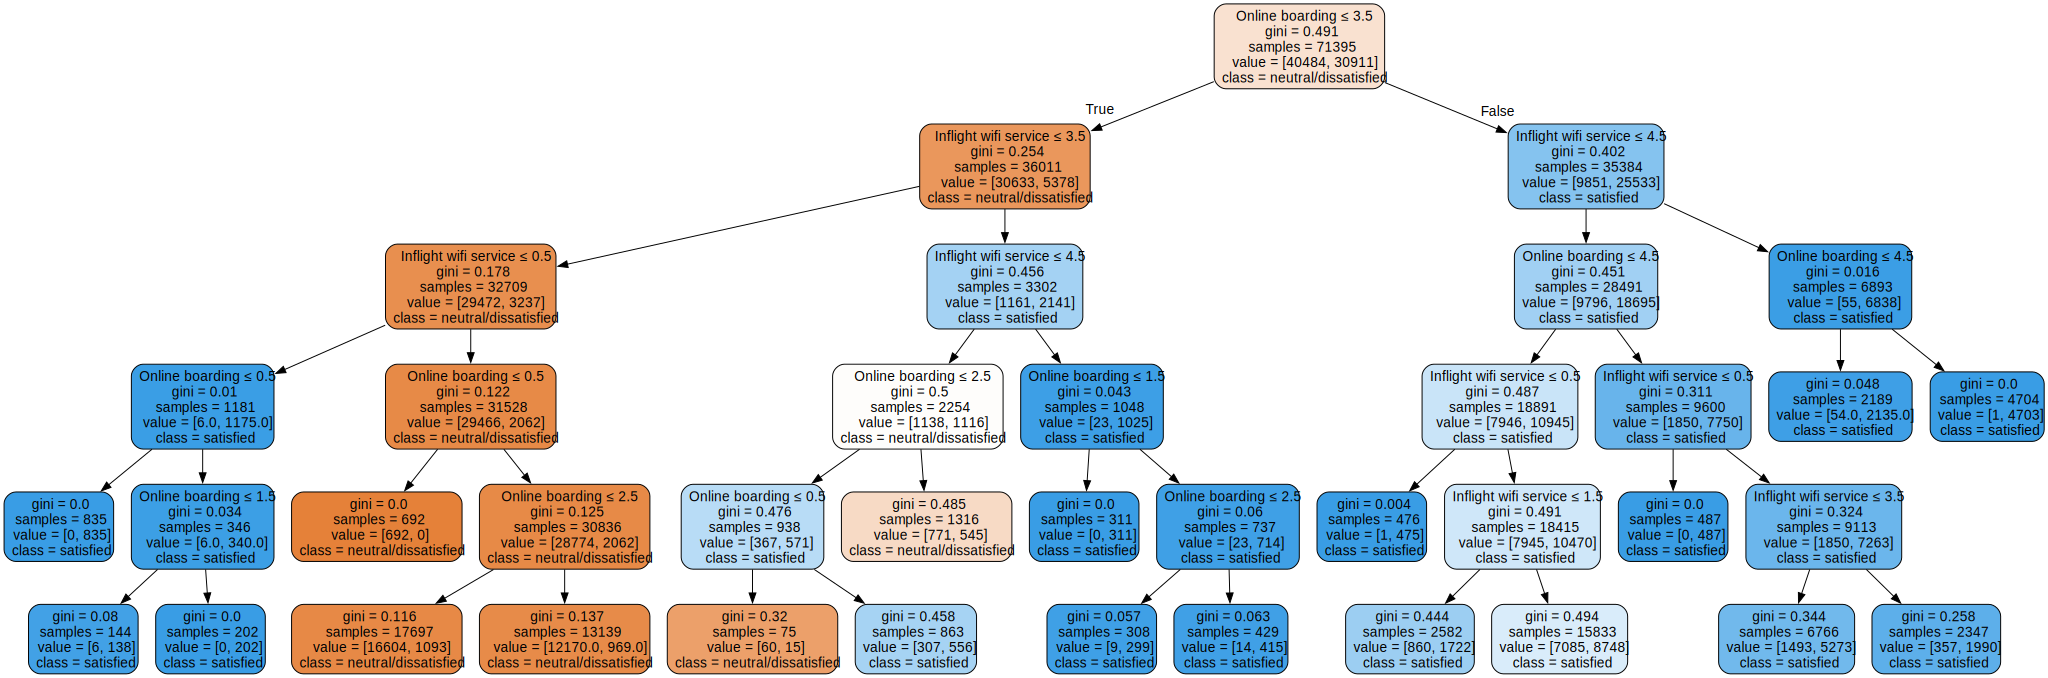

In [41]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

dot_data = export_graphviz(
    dt_depth,
    out_file=None,
    feature_names=['Online boarding', 'Inflight wifi service'],
    class_names=['neutral/dissatisfied', 'satisfied'],
    filled=True,
    rounded=True,
    special_characters=True
)

graph = Source(dot_data)
graph

#### Почему предикаты в новом дереве решений не целые, а кратные 1/2?
Алгоритм построения дерева решений работает с упорядоченными данными, выбирая пороговое значение для разбиения. Он берёт два соседних значения признаков и выбирает их среднее арифметическое. В наших двух признаках `Online boarding` и `Inflight wifi service` встречаются целочисленные значени от 0 до 5. Для двух целых чисел среднее арифметическое получается всегда кратно 1/2, поэтому все пороги получаются кратными 1/2, чтобы не было неопределенности при классификации значений, равных порогу.

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

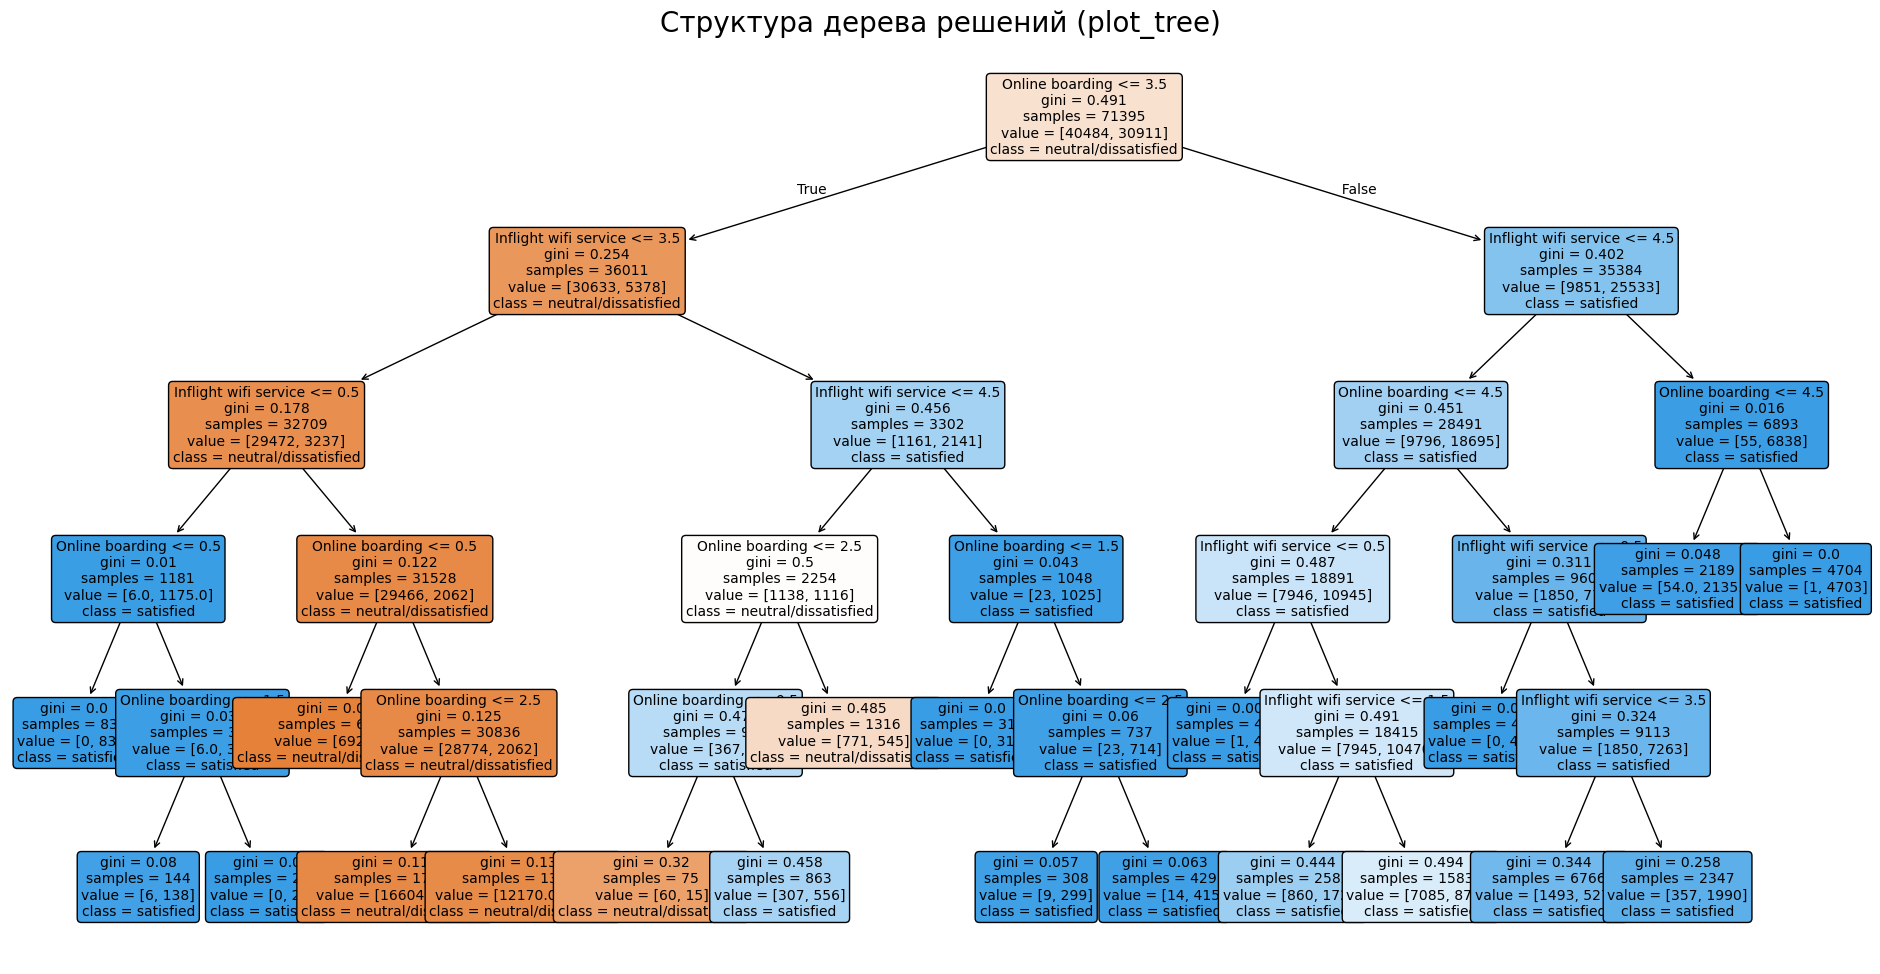

In [42]:
plt.figure(figsize=(24, 12))

plot_tree(
    dt_depth,
    feature_names=['Online boarding', 'Inflight wifi service'],
    class_names=['neutral/dissatisfied', 'satisfied'],
    filled=True,
    rounded=True,
    fontsize=10
)

plt.title('Структура дерева решений (plot_tree)', fontsize=20)
plt.show()

Дерево получилось несимметричным. Это нормально, скорее даже хорошо, потому что в таком случае дерево идёт в глубину только там, где это нужно, то есть адаптируется к сложности данных. Если сплит не даёт прироста информации, то ветвление прекращается. Таким образом, видя, что дерево несимметрично, мы понимаем, что алгоритм работает эффективно.

### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

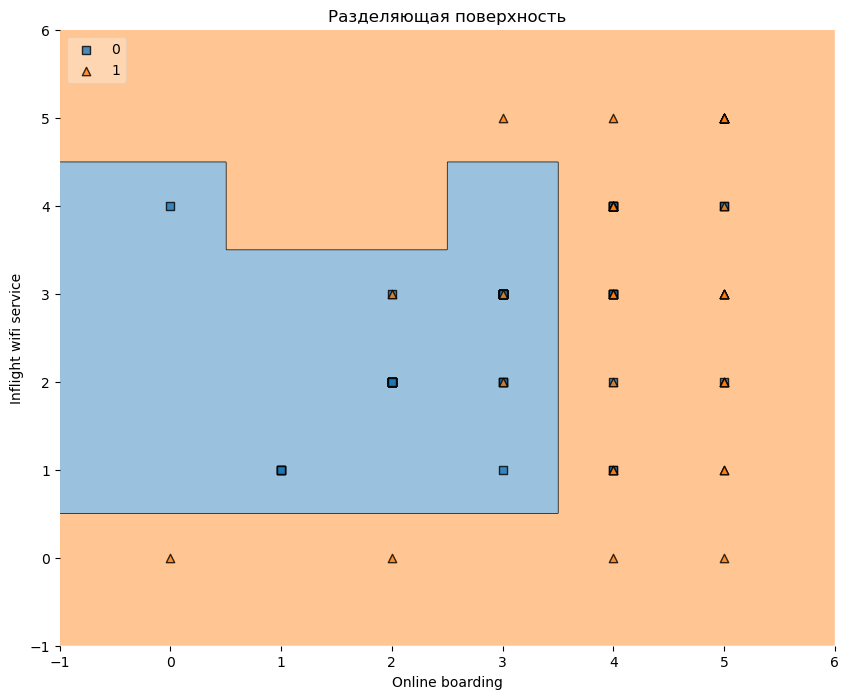

In [43]:
warnings.filterwarnings("ignore", category=UserWarning)

X_pl = X_train_enc[['Online boarding', 'Inflight wifi service']].iloc[:100].values
y_pl = y_train.iloc[:100].values.astype(int)

plt.figure(figsize=(10, 8))
plot_decision_regions(X_pl, y_pl, clf=dt_depth, legend=2)

plt.xlabel('Online boarding')
plt.ylabel('Inflight wifi service')
plt.title(f'Разделяющая поверхность')
plt.show()

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

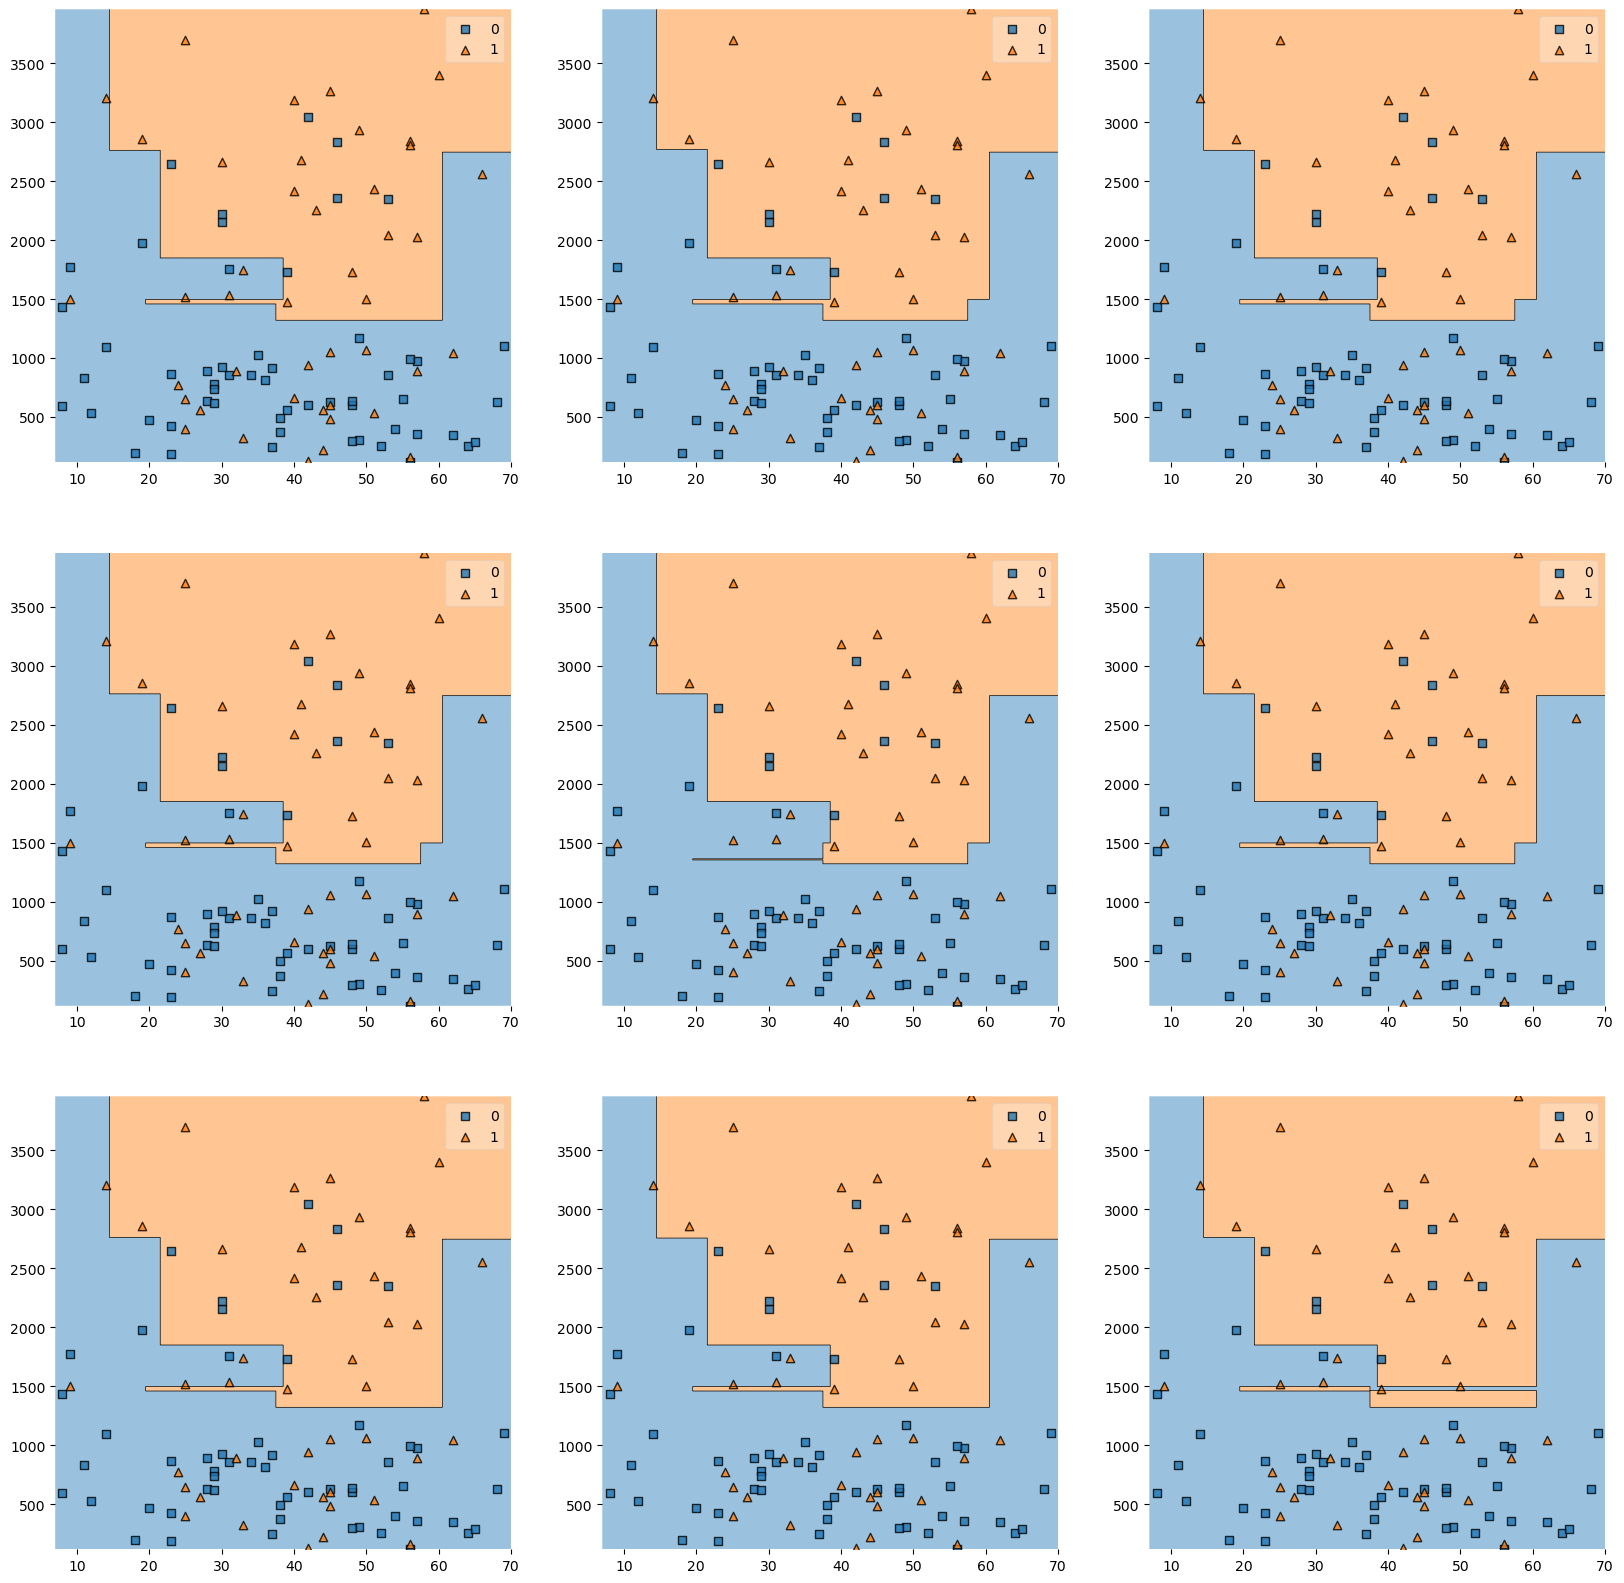

In [44]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train.index, size=X_train.shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train.loc[inds, ['age', 'Flight Distance']], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=X_train[['age', 'Flight Distance']].iloc[:100, :].values, y=np.array(y_train[:100]), ax=ax[row][col])

**Смотрите как двигается граница, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [45]:
%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_enc, y_train)
    y_predicted_train = DT.predict(X_train_enc)
    y_predicted_val = DT.predict(X_val_enc)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

CPU times: total: 4.38 s
Wall time: 4.54 s


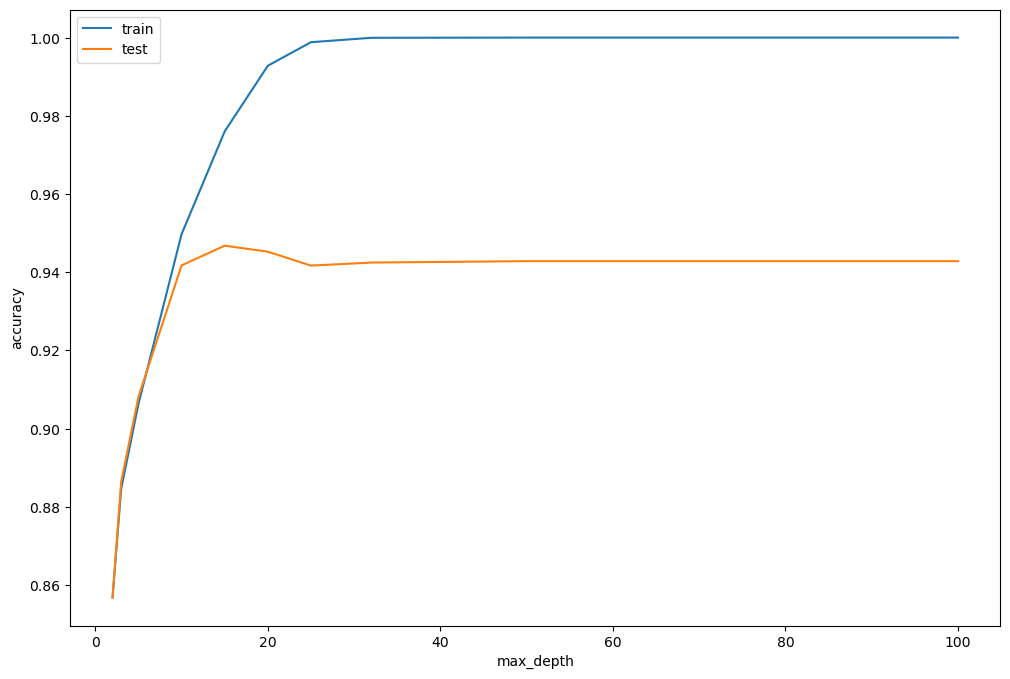

In [46]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [47]:
params = {
    'max_depth': np.arange(10, 25, 1),
    'min_samples_leaf': np.arange(15, 30, 1),
    'criterion': ['gini', 'entropy']
}
    

dt_gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
dt_gs.fit(X_train_enc, y_train)

print(f'Лучшие параметры: {dt_gs.best_params_}')
print(f'Лучшее Accuracy на кросс-валидации: {dt_gs.best_score_:.3f}')

best_dt = dt_gs.best_estimator_

y_val_pred = best_dt.predict(X_val_enc)
dt_accuracy = accuracy_score(y_val, y_val_pred)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
Лучшие параметры: {'criterion': 'entropy', 'max_depth': np.int64(24), 'min_samples_leaf': np.int64(20)}
Лучшее Accuracy на кросс-валидации: 0.949


### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [48]:
with open('DT.pkl', 'wb') as f:
    pickle.dump(best_dt, f)

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [49]:
rf_def = RandomForestClassifier(random_state=42)
rf_def.fit(X_train_enc, y_train)
rf_def_acc = accuracy_score(y_val, rf_def.predict(X_val_enc))

print(f'Accuracy случайного леса с параметрами по умолчанию: {rf_def_acc:.4f}')

Accuracy случайного леса с параметрами по умолчанию: 0.9612


Даже с дефолтными параметрами случайного леса, мы получили выигрыш более, чем на одну сотую, в сравнении с лучшей моделью одиночного дерева. Как мы знаем из теории, случайный лес значительно уменьшает разброс, сохраняя при этом смещение.

### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

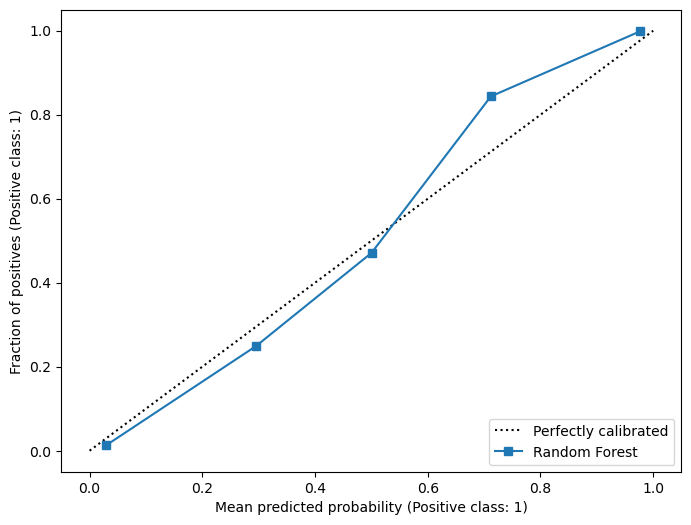

In [50]:
fig, ax = plt.subplots(figsize=(8, 6))

disp = CalibrationDisplay.from_estimator(rf_def, X_val_enc, y_val, n_bins=5, strategy='uniform', ax=ax, name='Random Forest')

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?

Как было выведено на лекции, вероятность в листе дерева вычисляется как доля объектов положительного класса `P = k/n`. Если в дереве не ограничить максимальную глубину, то оно будет разбивать вершины до тех пор, пока в листе не останутся объекты одного класса. То есть, получится, что дерево выдаёт вероятности либо 0, либо 1. Из-за этого ошибка получится большой, модель становится излишне самоуверенной.

В случае леса получается ситуация, когда он усредняет значение вероятностей по всем его деревьям. А так как подмножества у нас случайные, попадутся такие, что увидят отличные данные от остальных и выдадут другую информацию. Из-за этого в центре будет честная информация, а по краям - нет. Получится форма, похожая на сигмоиду.

### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

In [51]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_enc)
X_val_sc = scaler.fit_transform(X_val_enc)

lr = LogisticRegression(random_state=42)
lr.fit(X_train_sc, y_train)

lr_accuracy = accuracy_score(y_val, lr.predict(X_val_sc))

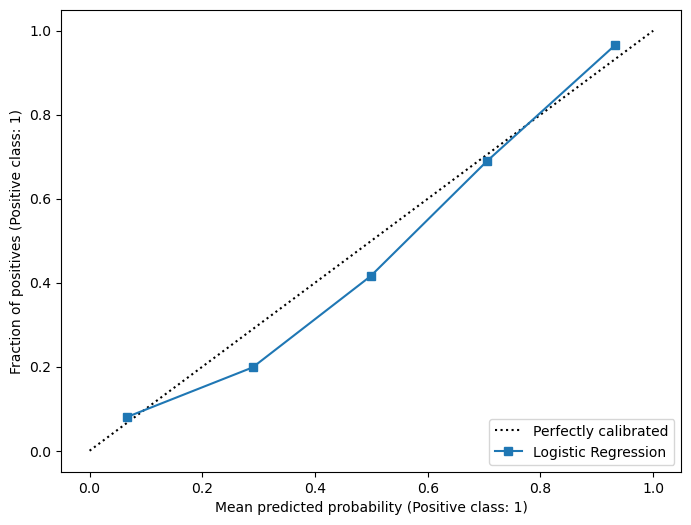

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))

CalibrationDisplay.from_estimator(lr, X_val_sc, y_val, n_bins=5, strategy='uniform', ax=ax, name='Logistic Regression')

plt.show()

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?

Логистическая регрессия обучается, минимизируя log-loss, который штрафует модель за неверную оценку вероятности (выводили вероятностную постановку логистической регрессии на лекции с помощью ММП). То есть математический минимум этого функционала достигается, когда предсказание модели совпадает с истинной вероятностью. Логистическая регрессия в каждой точке x пространства объектов предсказывает вероятность того, что x принадлежит к положительному классу. Использование сигмоиды позволяет строить гладкое непрерывное вероятностное поле.

### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

In [53]:
sigmoid = CalibratedClassifierCV(rf_def, method='sigmoid', cv='prefit')
sigmoid.fit(X_val_enc, y_val)

isotonic = CalibratedClassifierCV(rf_def, method='isotonic', cv='prefit')
isotonic.fit(X_val_enc, y_val)

C:\Users\user\anaconda3\envs\ml_hw4\lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\user\anaconda3\envs\ml_hw4\lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


CalibratedClassifierCV(cv='prefit',
                       estimator=RandomForestClassifier(random_state=42),
                       method='isotonic')

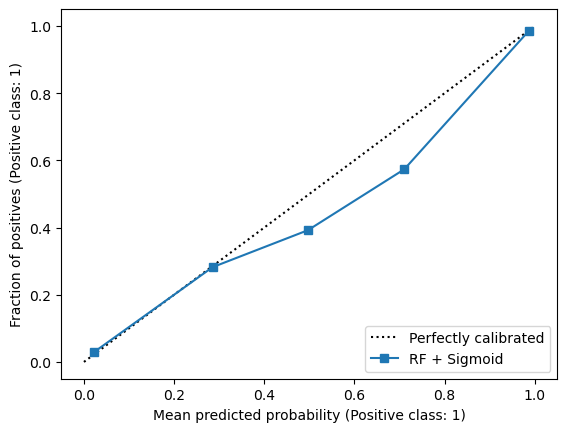

In [54]:
sig = CalibrationDisplay.from_estimator(sigmoid, X_val_enc, y_val, n_bins=5, strategy='uniform', name='RF + Sigmoid')

plt.show()

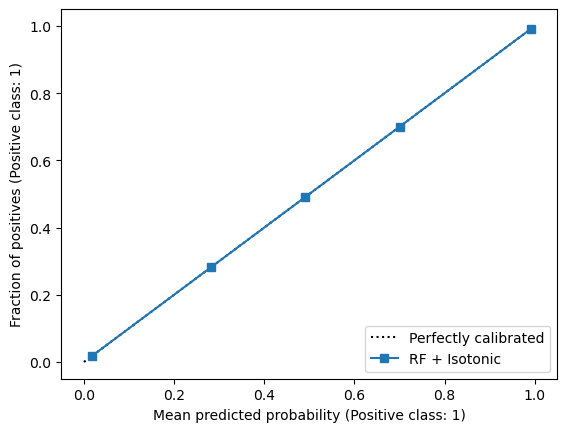

In [55]:
iso = CalibrationDisplay.from_estimator(isotonic, X_val_enc, y_val, n_bins=5, strategy='uniform', name='RF + Isotonic')
plt.show()

Как мы видим, изотоническая калибровка показала идеальный результат. То есть, если откалиброванная модель делает предсказание, то мы можем быть уверены, что вероятность наиболее близка к реальной. Для калибровки Платта кривая стала выглядеть чуть лучше, но все равно имеет прогибЮ начиная с вероятности ~0.3. Калибровка Платта хорошо подходит, когда кривая очень похожа на сигмоиду и пытается выпрямить её, в нашем случае это было не так. А вот изотоническая калибровка более гибкая и отлично работает на больших объемах данных, поэтому показала отличный результат.

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)

#### Гистограммная калибровка
Интервал предсказанных вероятностей разбивается на K бинов, обычно равной ширины. Для каждого бина на валидационной выборке вычисляется доля положительного класса. При предсказании для нового объекта модель сначала выдает сырую вероятность, мы смотрим, в какой бин она попадет, и заменяет её на заранее вычисленное значение для этого бина. https://education.yandex.ru/handbook/ml/article/kak-ocenivat-veroyatnosti

#### Бета-калибровка
Параметрический метод, являющийся логическим развитием метода Платта. Если метод Платта опирается на логистическую функцию, то бета-калибровка использует семейство бета-распределений. Бета-калибровка более гибкая. https://probably.tidymodels.org/reference/cal_estimate_beta.html

#### Масштабирование температуры
Это техника управления вероятностным распределением выходов модели, при которой логиты (не нормализованные значения перед функцией Softmax) делятся на коэффициент температуры T. Этот метод применяется для сглаживания или усиления распределения вероятностей, что напрямую влияет на разнообразие и уверенность модели в своих предсказаниях. Метод стал стандартом в Deep Learning. https://aiew.ru/glossary/temperature-scaling/

### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [56]:
error_rf, bias_rf, var_rf = bias_variance_decomp(rf_def, X_train_np, y_train_np,  X_val_np, y_val_np, loss='0-1_loss', random_seed=42)

print(f'Смещение полученного случайного леса: {bias_rf}')
print(f'Разброс полученного случайного леса: {var_rf}')

Смещение полученного случайного леса: 0.03934640522875817
Разброс полученного случайного леса: 0.00906127450980392


По сравнению с одним деревом решений смещение осталось примерно на том же уровне, а вот разброс сильно уменьшился. В теории так и должно происходить, потому что в случайном лесе мы используем бэггинг, принцип которого заключается в том, что каждое дерево строится на своей бутстрап выборке. Усредняя результаты N деревьев, обученных на своих выборках, мы снижаем разброс пропорционально числу деревьев (тут, конечно, есть отличия от теории, потому что в реальности нельзя достичь снижения дисперсии в N раз, так как деревья хоть и немного, но будут кореллированы). Корреляция между деревьями снижается благодаря тому, что для каждой вершины в дереве случайным образом выбирается свой набор признаков для предиката, но полностью убрать корреляцию всё равно не получится. Что касается смещения: так как мат ожидание предсказания леса равно мат ожиданию одного дерева (в лесу мат ожидания каждого дерева одинаковы, поэтому при усреднении получается одно и то же), то и смещение будет одинаковым.

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [57]:
error_lr, bias_lr, var_lr = bias_variance_decomp(lr, X_train_np, y_train_np,  X_val_np, y_val_np, loss='0-1_loss', random_seed=42)

print(f'Смещение логистической регрессии: {bias_lr}')
print(f'Разброс логистической регрессии: {var_lr}')

Смещение логистической регрессии: 0.1538562091503268
Разброс логистической регрессии: 0.0219797385620915


Смещение логистической регрессии получилось в несколько раз больше, чем у древесных алгоритмов, а разброс оказался меньше, чем о одиночного дерева, но больше, чем у случайного леса. Логистическая регрессия является линейным алгоритмом, что предполагает разделение довольных клиентов от недовольных гиперплоскостью. Такая модель получается достаточно устойчивой. Если мы внесём небольшие изменения в выборке, то это почти не повлияет на гиперплоскость (поэтому низкий разброс), но из-за того, что в реальности удовлетворенность и неудовлетворенность клиентов имеют нелинейную зависимость от признаков, линейная модель не может описать такие данные.

Таким образом, случайный лес является оптимальным выбором среди рассмотренных моделей: он демонстрирует более низкое смещение и разбор, чем у остальных алгоритмов.

### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [58]:
from scipy.stats import randint, uniform

params_rf = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(10, 35),
    'min_samples_leaf': randint(1, 20),
    'max_features': uniform(0.1, 0.8),
    'criterion': ['gini', 'entropy']
}

rf_rs = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=params_rf,
    n_iter=20, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

rf_rs.fit(X_train_enc, y_train)

print(f"Лучшие параметры: {rf_rs.best_params_}")
print(f"Лучшее Accuracy на CV: {rf_rs.best_score_:.4f}")

best_rf = rf_rs.best_estimator_
rf_tuned_acc = accuracy_score(y_val, best_rf.predict(X_val_enc))
print(f"Accuracy на валидации: {rf_tuned_acc:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры: {'criterion': 'entropy', 'max_depth': 23, 'max_features': np.float64(0.746717878493169), 'min_samples_leaf': 9, 'n_estimators': 139}
Лучшее Accuracy на CV: 0.9609
Accuracy на валидации: 0.9618


C помощью подбора гиперпараметров не удалось достичь большого прироста качества предсказания. Это объясняется тем, что при дефолтных параметрах случайный лес хорошо справляется с переобучением, усредняя ответы одиночных деревьев.

## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [59]:
cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_enc[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

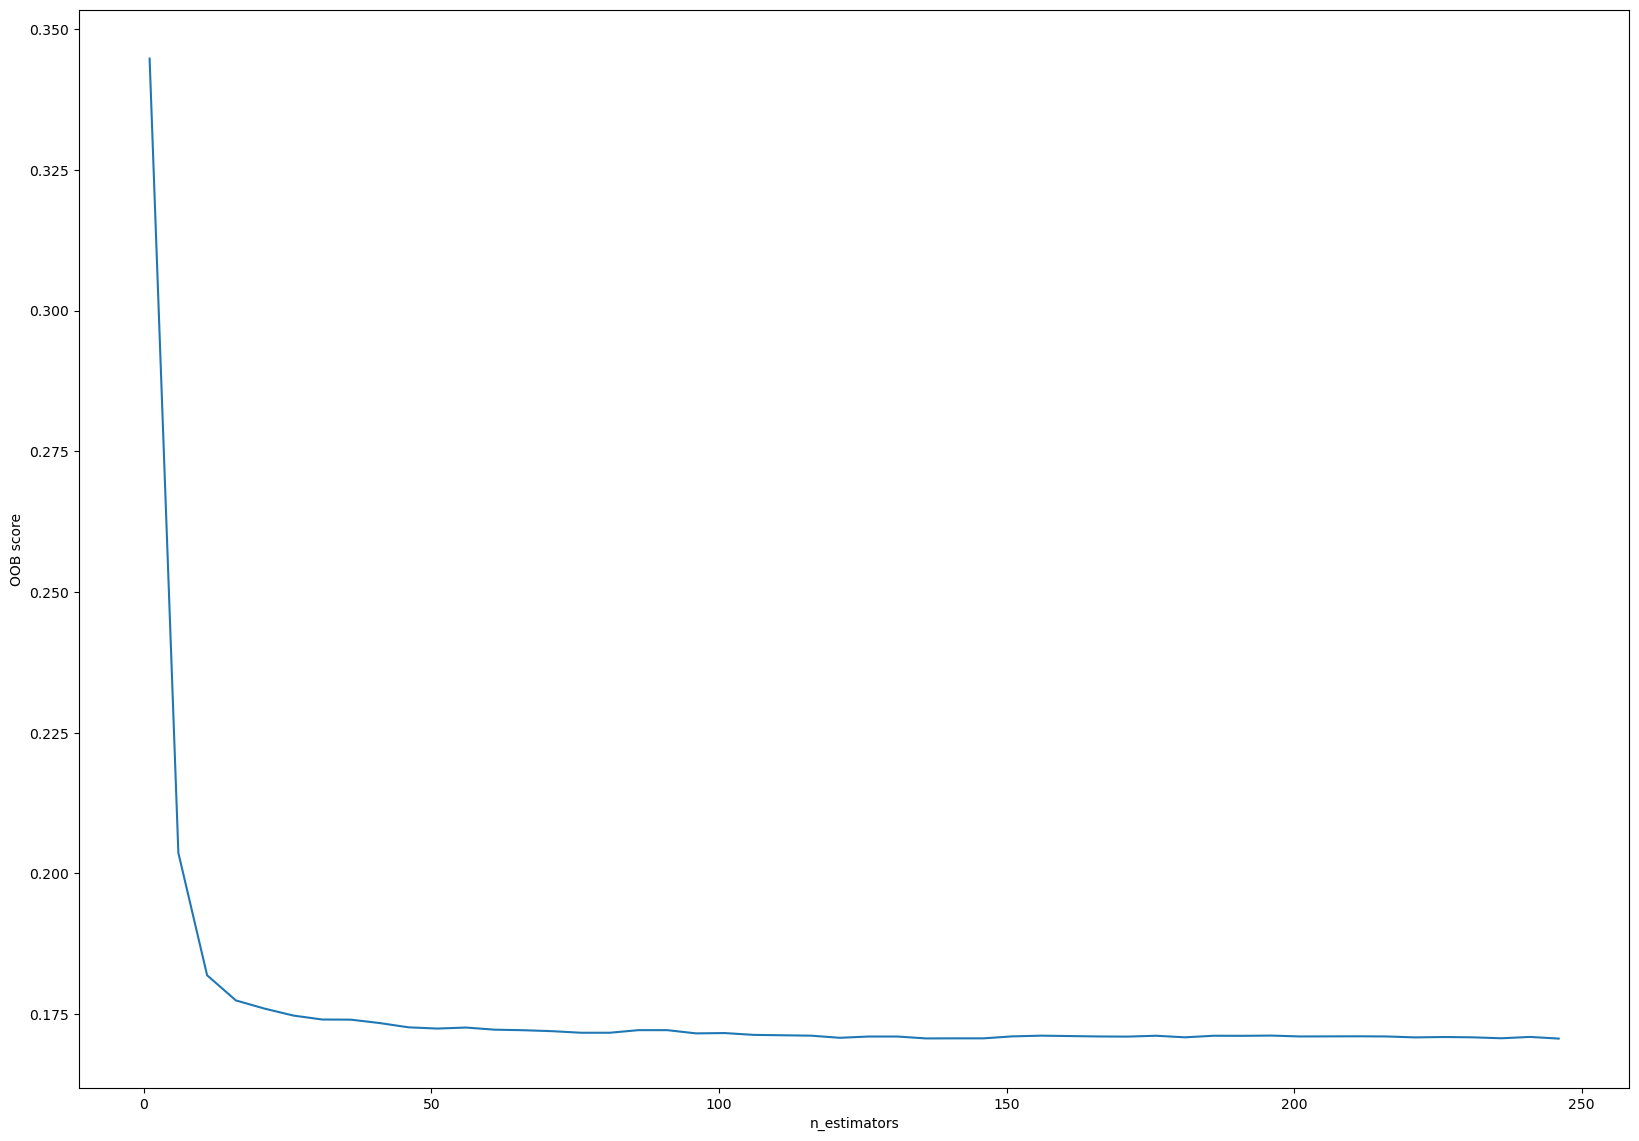

In [60]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


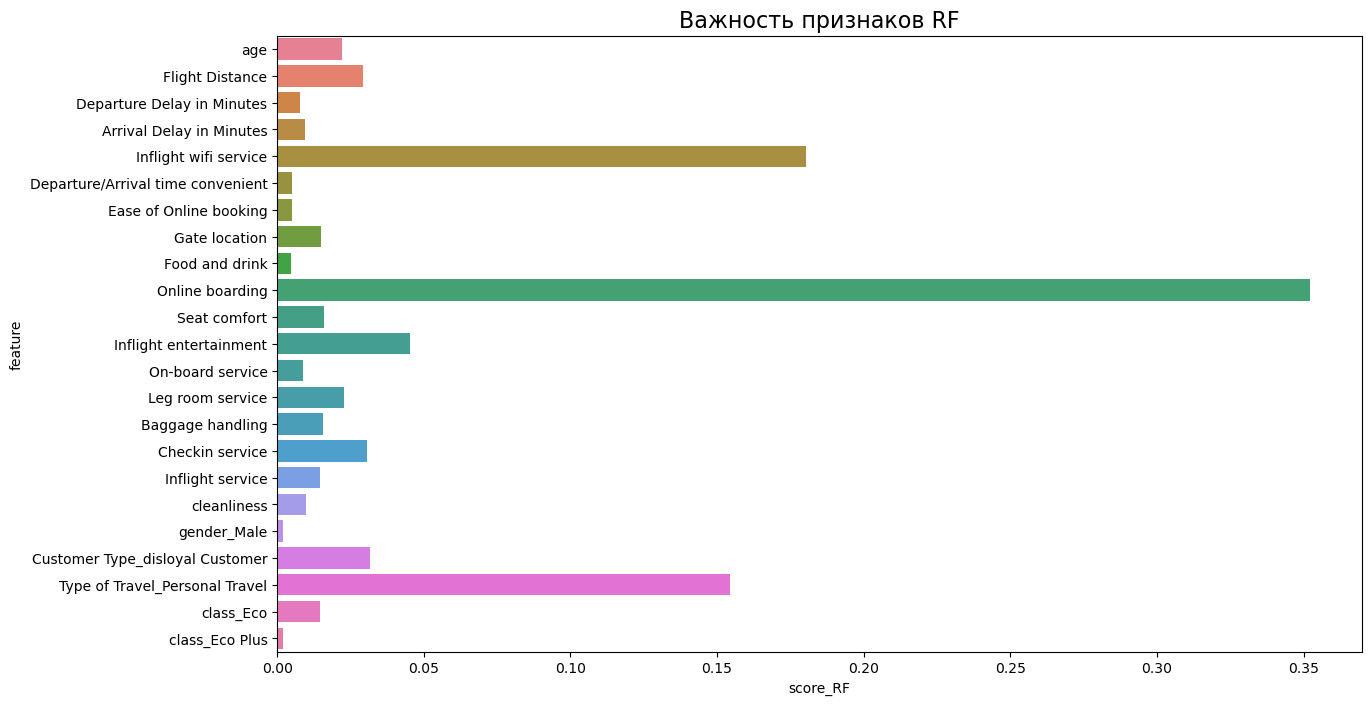

Самые важные признаки:
                            feature  score_RF
9                   Online boarding  0.292206
4             Inflight wifi service  0.195221
20   Type of Travel_Personal Travel  0.139614
11           Inflight entertainment  0.059529
19  Customer Type_disloyal Customer  0.052503
21                        class_Eco  0.032608
15                  Checkin service  0.029639


In [67]:
fimp_rf = pd.DataFrame({'feature': X_train_enc.columns, 'score_RF': best_rf.feature_importances_})

plt.figure(figsize=(14, 8))
sns.barplot(data=fimp_df, x='score_DT', y='feature', hue='feature', palette='husl', legend=False)

plt.title('Важность признаков RF', fontsize=16)
plt.xlabel("score_RF")
plt.ylabel("feature")

plt.show()

print('Самые важные признаки:')
print(fimp_rf.sort_values(by='score_RF', ascending=False).head(7))

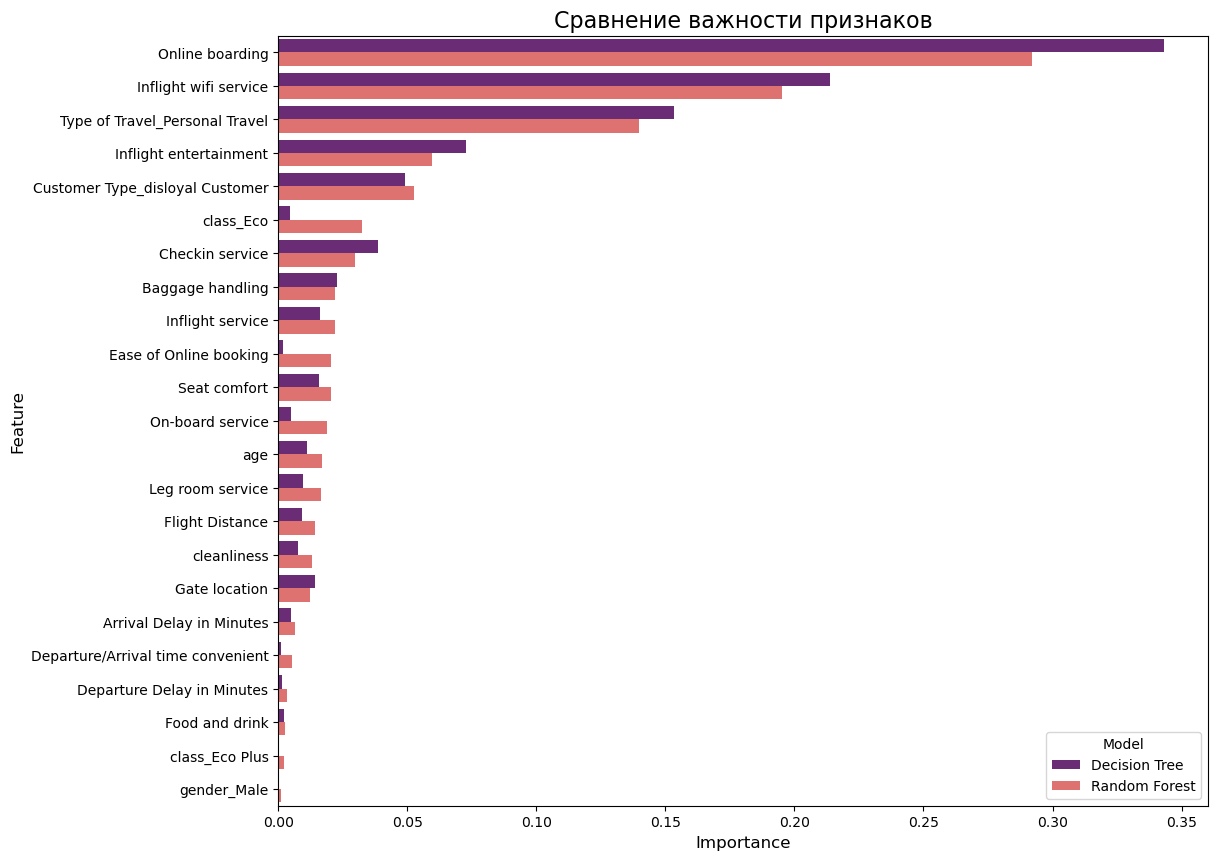

In [66]:
fimp_comp = pd.DataFrame({'feature': X_train_enc.columns,
    'Decision Tree': best_dt.feature_importances_,
    'Random Forest': best_rf.feature_importances_
})

fimp_melt = fimp_comp.melt(id_vars='feature', var_name='Model', value_name='Importance')
order = fimp_comp.sort_values(by='Random Forest', ascending=False)['feature']

plt.figure(figsize=(12, 10))
sns.barplot(data=fimp_melt, y='feature', x='Importance', hue='Model', order=order, palette='magma')

plt.title('Сравнение важности признаков', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

Четыре самых важных признака у одиночного дерева и леса совпадают, однако, можно заметить, что решающее дерево более жадное. Этим четырём признаком оно отдало бОльшую часть важности. Многие из признаков из низа списка для решающего дерева имеют важность близкую к нулю, а для случайного леса это не так. Из-за того, что в случайном лесе мы ограничиваем количество признаков для выбора в каждой из вершин, не везде самые важные признаки попадают в эту выборку, поэтому дерево из леса начинает искать другие зависимости, становясь не таким жадным. По итогу важность распределяется между признаками равномернее.

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

In [68]:
import pickle

with open('RF.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

C:\Users\user\AppData\Local\Temp\ipykernel_11384\3180605337.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1], X_sample)


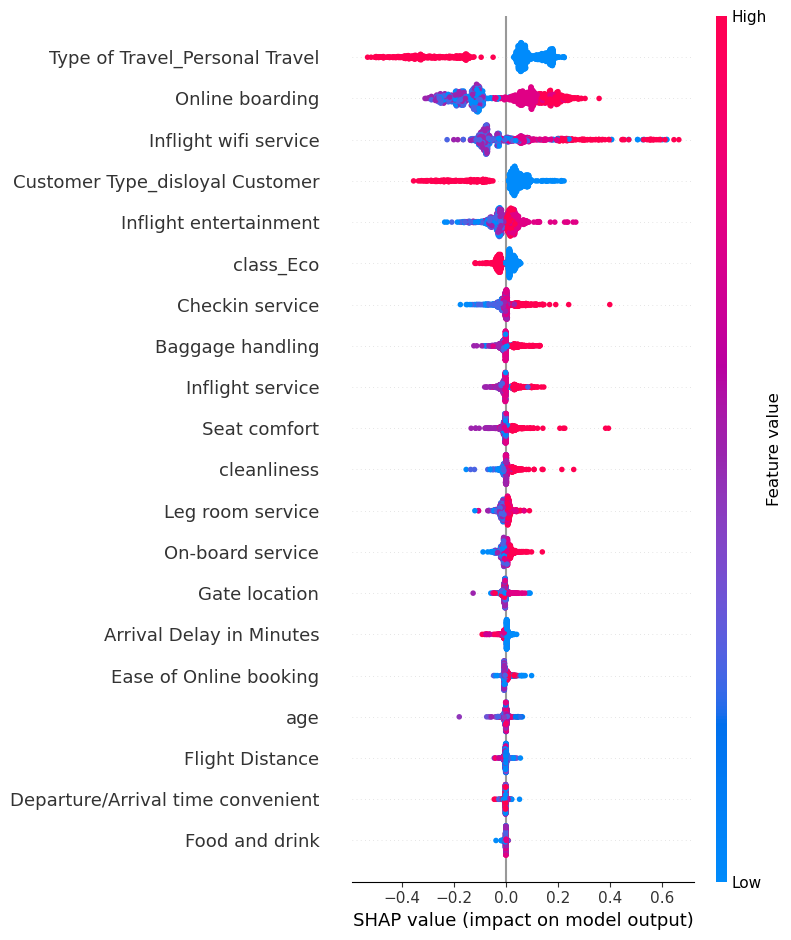

In [69]:
X_sample = X_train_enc.sample(1000, random_state=42)

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values[:, :, 1], X_sample)

Главным преимуществом такой интерпретации моделей является учёт направления, в какую сторону значения признака двигают предсказания. Каждая точка на графике - это один из 1000 пассажиров из подвыборки. По оси Y признаки отсортированы по важности, а по оси X показывается влияние признака: если точки справа от нуля, то это значения признака, увеличивающие вероятность того, что пассажир будет доволен, а если слева - того, что недоволен. Красным цветом обозначены высокие значения признака, синим - низкие.

Видим, что признак `Personal Travel` определился как самый важный. Красные точки, говорящие о том, что тип полёта данного пассажира - личный, находятся чётко слева от нуля, что свидетельствует о недовольстве таких пассажиров. Если же тип полёта - деловой, то клиент в большинстве случаев остаётся доволен.

Признак `Online boarding` является вторым по важности. По графику видим, что пассажиры, поставившие высокую оценку данному критерию, остаются в основном довольны полётом. Это говорит о том, что высокое качество онлайн бронирования оказывает большое влияние на впечатление от всего полёта.

Признак `Inflight wifi service` является третьим по важности. Анализируя визуализацию, можно сделать вывод о том, что клиенты, поставившие высокую оценку качеству вайфая, преимущественно остаются довольны полётом, поэтому наличие качественного вайфая - важный фактор.

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

#### Детальная интерпретация
Watefall plot показывает, как мы шли от среднего по всем значения к финальному ответу, прибавляя и вычитая вклады для каждого из признаков. Force plot также помогает детализировать решение.

#### Корреляция признаков
Dependence plot помогает увидеть, как один признак влияет на другой. Также SHAP позволяет вычислить матрицу, которая показывает эффект от совместного присутствия признаков i и j.

#### Интерпретация любой модели
KernelSHAP позволяет интерпретировать любою модель. В библиотеке также есть методы, позволяющие интерпретировать нейронные сети.

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [71]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_enc.values,
    feature_names=X_train_enc.columns.tolist(),
    class_names=['neutral/dissatisfied', 'satisfied'],
    mode='classification'
)

observation = X_val_enc.iloc[7]

exp = explainer_lime.explain_instance(
    observation.values, 
    best_rf.predict_proba, 
    num_features=10
)

exp.show_in_notebook(show_table=True)

LIME работает иначе, чем SHAP. Он объясняет только один конкретный прогноз. LIME выбирает один объект, шумит его признаками и наблюдает, как меняется предсказание леса. На этих зашумленных данных строится простая модель, а коэффициенты этой модели и есть важности, которые выводятся на графике. Так мы понимаем, как нужно изменить признаки этого конкретного пассажира, чтобы модель поменяла своё мнение.

В моём случае попался очень лояльный пассажир и модель уверена в его удовлетворенности на 100%. Он летит деловым полётом, является лояльным клиентом и поставил 5 за онлайн бронирование, что является доминирующими факторами для того, чтобы классифицировать его как полностью удовлетворенного.

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

Для меня домашнее задание оказалось весьма полезным, оно затроонуло все теоретические аспекты с лекций и позволило подробнее в них разобраться и 'прощупать' на практике. Получилось детальнее разобраться в принципе работы дерева и случайного леса, устаканить в голове калибровки (а также изучить незнакомы) и разложение ошибки на смещение и разброс. Также полезным оказалось применение библиотек для интерпретации результатов, о которых я раньше не знал.

Само домашнее задание не показалось сложным, а вот его размер впечатляет. По личным ощущениям, лишнего в ДЗ нету, разве что моментами missingno показался избыточным, но, вероятно, на это повлиял сам характер наших данных. На выполнение домашнего задания ушло около 25-30 часов, чтобы разобраться с некоторыми моментами подробнее и ознакомиться с ранее неизученными библиотеками. Большое количество времени съела очистка данных, EDA и формулировка выводов, но это классика. 

Спасибо за внимание!